In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections
from scipy import stats

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

import datashader as ds
import colorcet

import powerplot
importlib.reload(powerplot)

import _powerplot_vizgen_merfish
importlib.reload(_powerplot_vizgen_merfish)
from _powerplot_vizgen_merfish import *

Fangming, can you please compare the
CA1 cluster, C15 (with substantial RV
labeling DsRed+) on the right to the left
C15 one (no RV label) in this same section
to see if there is any potential difference?

Fangming, can you please see attached, and address my request on page 3 of the attached PDF?  
> In the meantime, Fangming can you please look at what George did for us, and see if you can locate DsRed cells and examine their gene expression profiles? 
Perhaps also pick up a few cells in the image (2-6 R1, right side) shown on page 4 of the attached PDF, and identify their cell types by gene expression profiles (say excitatory vs inhibitory).  

Do you have time for anther ZOOM on Monday?  Thank you!

In [2]:
today = datetime.date.today()
analysis_name = "AD_mouse_dsred"
figures = '../figures/{}_{}_{{}}'.format(today, analysis_name)
results = '../data/{}_{}_{{}}'.format(today, analysis_name)
figures, results

('../figures/2021-06-08_AD_mouse_dsred_{}',
 '../data/2021-06-08_AD_mouse_dsred_{}')

# read data

In [3]:
files = [
    '../data/raw_admouse/Xulab_2_6_region_0_sequential_sum_signals.csv',
    '../data/raw_admouse/Xulab_2_6_region_1_sequential_sum_signals.csv',
]

# new info - [bits, DsRed, DAPI, polyT]

dsred = []
for file in files:
    df = pd.read_csv(file, index_col=0)
    dsred.append(df)
dsred = pd.concat(dsred)
print(dsred.shape)
dsred.head()

(300808, 21)


bit1         bit2  \
174654794983965771624934359020727021519  1136.577143  1543.813714   
205001521576354058004160876735897606082  1102.736757  1437.877565   
7046461620956594698843190854957640378    1095.644037  1312.950882   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1329.145522  1607.791266   

                                                bit3         bit4  \
174654794983965771624934359020727021519  1186.177143  1242.625143   
205001521576354058004160876735897606082  1159.035135  1211.136516   
7046461620956594698843190854957640378    1131.750176  1190.718843   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1564.806810  1510.697409   

                                                bit5         bit6  \
174654794983965771624934359020727021519  1614.773714  1260.038857   
205001521576354058004160876735897606082  1514.261902  1235.577980   
7046461620956594698843190854957640378    1408.839944  1208.068878   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1678.023538  1559.047668   

                                                bit7         bit8  \
174654794983965771624934359020727021519  1265.203429  1602.193143   
205001521576354058004160876735897606082  1231.183586  1510.148988   
7046461620956594698843190854957640378    1195.652364  1407.459986   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1468.012139  1734.694152   

                                                bit9        bit10  ...  \
174654794983965771624934359020727021519  1242.076571  1271.857143  ...   
205001521576354058004160876735897606082  1216.474856  1240.032453  ...   
7046461620956594698843190854957640378    1194.068454  1198.397459  ...   
92422298148451050383038371863772483863           NaN          NaN  ...   
21747888194846983743587184577248998723   1504.943153  1460.549519  ...   

                                               bit12        bit13  \
174654794983965771624934359020727021519  1213.361143  1286.507429   
205001521576354058004160876735897606082  1197.602789  1256.147110   
7046461620956594698843190854957640378    1164.094989  1205.252364   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1469.969504  1484.787713   

                                               bit14        bit15  \
174654794983965771624934359020727021519  1597.926857  1195.477714   
205001521576354058004160876735897606082  1476.947700  1163.374682   
7046461620956594698843190854957640378    1369.796048  1142.281722   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1739.621910  1409.403109   

                                               bit16        bit17  \
174654794983965771624934359020727021519  1321.898286  1584.785143   
205001521576354058004160876735897606082  1281.597425  1481.155424   
7046461620956594698843190854957640378    1217.226112  1359.312350   
92422298148451050383038371863772483863           NaN          NaN   
21747888194846983743587184577248998723   1481.452702  1618.492968   

                                               bit18       DsRed        polyT  \
174654794983965771624934359020727021519  1188.754286  422.667429  1972.138286   
205001521576354058004160876735897606082  1158.438648  415.714228  2072.549953   
7046461620956594698843190854957640378    1134.320677  404.394778  1805.196330   
92422298148451050383038371863772483863           NaN         NaN          NaN   
21747888194846983743587184577248998723   1340.926573  603.686899  2224.334271   

                                               DAPI  
174654794983965771624934359020727021519  541.004571  
205001521576354058004160876735897606082  514.800724  
7046461620956594698843190854957640378    503.7354

In [4]:
# palette as json
file = '../data/palette_admouse.json'
with open(file, 'r') as f:
    palette = json.load(f)

In [5]:
!ls ../data/*.tsv.gz

f = '../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-04.tsv.gz
../data/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-05.tsv.gz
(450001, 5)


cluster    umap_1    umap_2  \
cell                                                                  
1180572846630481441529138875642910508        C9  1.680950  3.928079   
123728997372594040247704579971571050130      C2  0.278196  2.377322   
141838298513381706222849139789989533595      C9  1.710492  4.529142   
159299836930912089601219931918867429346      C4  2.024679  5.750733   
178901354552570069198396499727421283408      C9  1.874690  5.392705   

                                                     sample cluster_cat  
cell                                                                     
1180572846630481441529138875642910508    Xulab_2_5_region_0          C9  
123728997372594040247704579971571050130  Xulab_2_5_region_0          C2  
141838298513381706222849139789989533595  Xulab_2_5_region_0          C9  
159299836930912089601219931918867429346  Xulab_2_5_region_0          C4  
178901354552570069198396499727421283408  Xulab_2_5_region_0          C9

In [6]:
input = '../data/processed_merfish_ad_mouse_rotated_june2_2021.hdf5'
samples = [
    'Xulab_2_5_region_0',
    'Xulab_2_5_region_1',
    'Xulab_2_6_region_0',
    'Xulab_2_6_region_1',
]

samples_annot = {
    'Xulab_2_5_region_0': 'WT 2-5',
    'Xulab_2_5_region_1': '5xFAD 2-5',
    'Xulab_2_6_region_0': 'WT 2-6',
    'Xulab_2_6_region_1': '5xFAD 2-6',
}


gmat = []
meta = []

for sample in samples:
    _gmat = pd.read_hdf(input, 'mat_'+sample)
    gmat.append(_gmat)
    _meta = pd.read_hdf(input, 'meta_'+sample)
    _meta['sample'] = sample 
    meta.append(_meta)

gmat = pd.concat(gmat)
meta = pd.concat(meta)

In [7]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta).join(dsred) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape, thedata[~thedata['DsRed'].isnull()].shape)

150 (450001, 150) (450001, 38) (220955, 38)


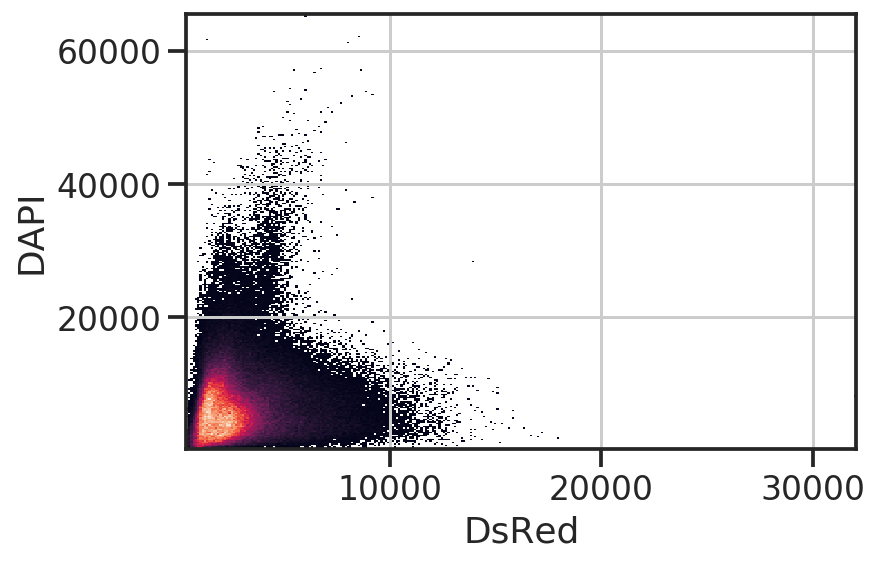

In [8]:
data = thedata
x, y = 'DsRed', 'DAPI'
npxlx, npxly = 300, 300

fig, ax = plt.subplots()
powerplot.massive_scatterplot_withticks(ax, data, x, y, npxlx, npxly)
plt.show()

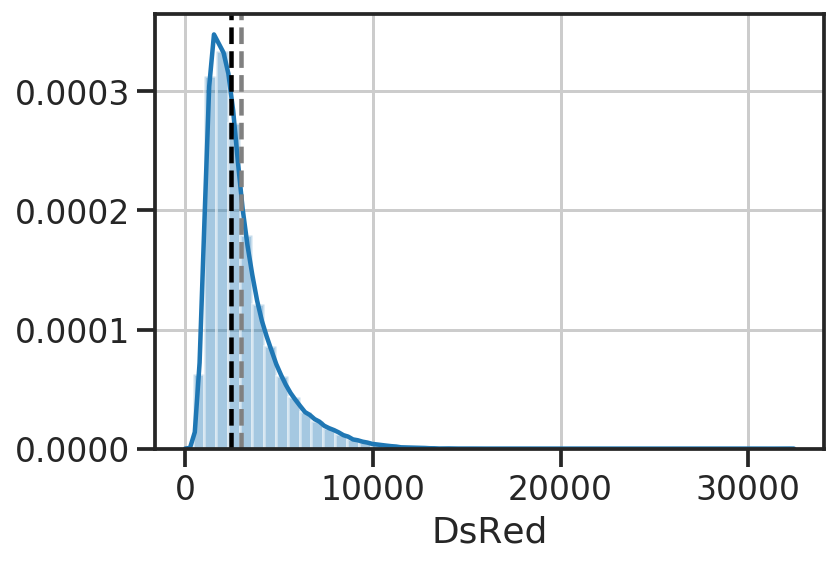

In [9]:
data = thedata
x = 'DsRed'

fig, ax = plt.subplots()
sns.distplot(data[x], ax=ax)
ax.axvline(data[x].median(), color='k', linestyle='--')
ax.axvline(data[x].mean(), color='gray', linestyle='--')
# ax.set_xscale('log')
plt.show()

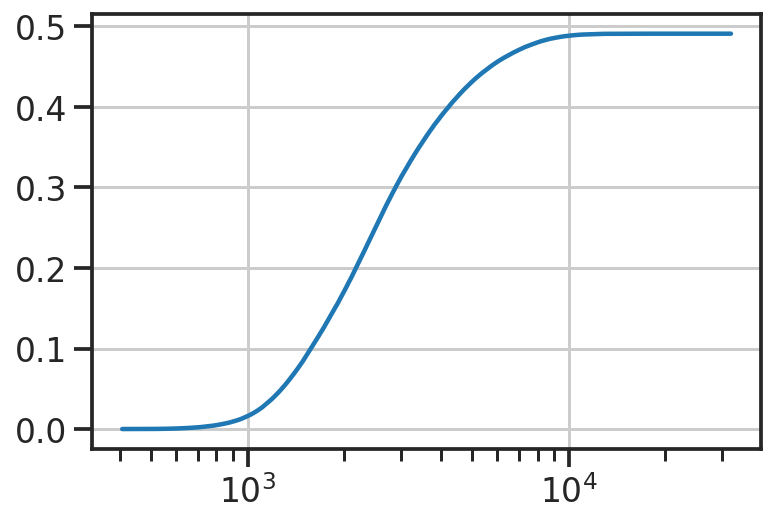

In [10]:
fig, ax = plt.subplots()
snmcseq_utils.gen_cdf(data[x], ax=ax)
ax.set_xscale('log')
plt.show()

In [11]:
thedata.groupby('sample').size()

sample
Xulab_2_5_region_0    119829
Xulab_2_5_region_1    107368
Xulab_2_6_region_0    111325
Xulab_2_6_region_1    111479
dtype: int64

In [12]:
thedata[~thedata['DsRed'].isnull()].groupby(['sample']).size()

sample
Xulab_2_6_region_0    110815
Xulab_2_6_region_1    110140
dtype: int64

### Run gene viz

  0%|          | 0/2 [00:00<?, ?it/s]/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


../figures/2021-06-08_AD_mouse_dsred_insitu_DsRed.pdf


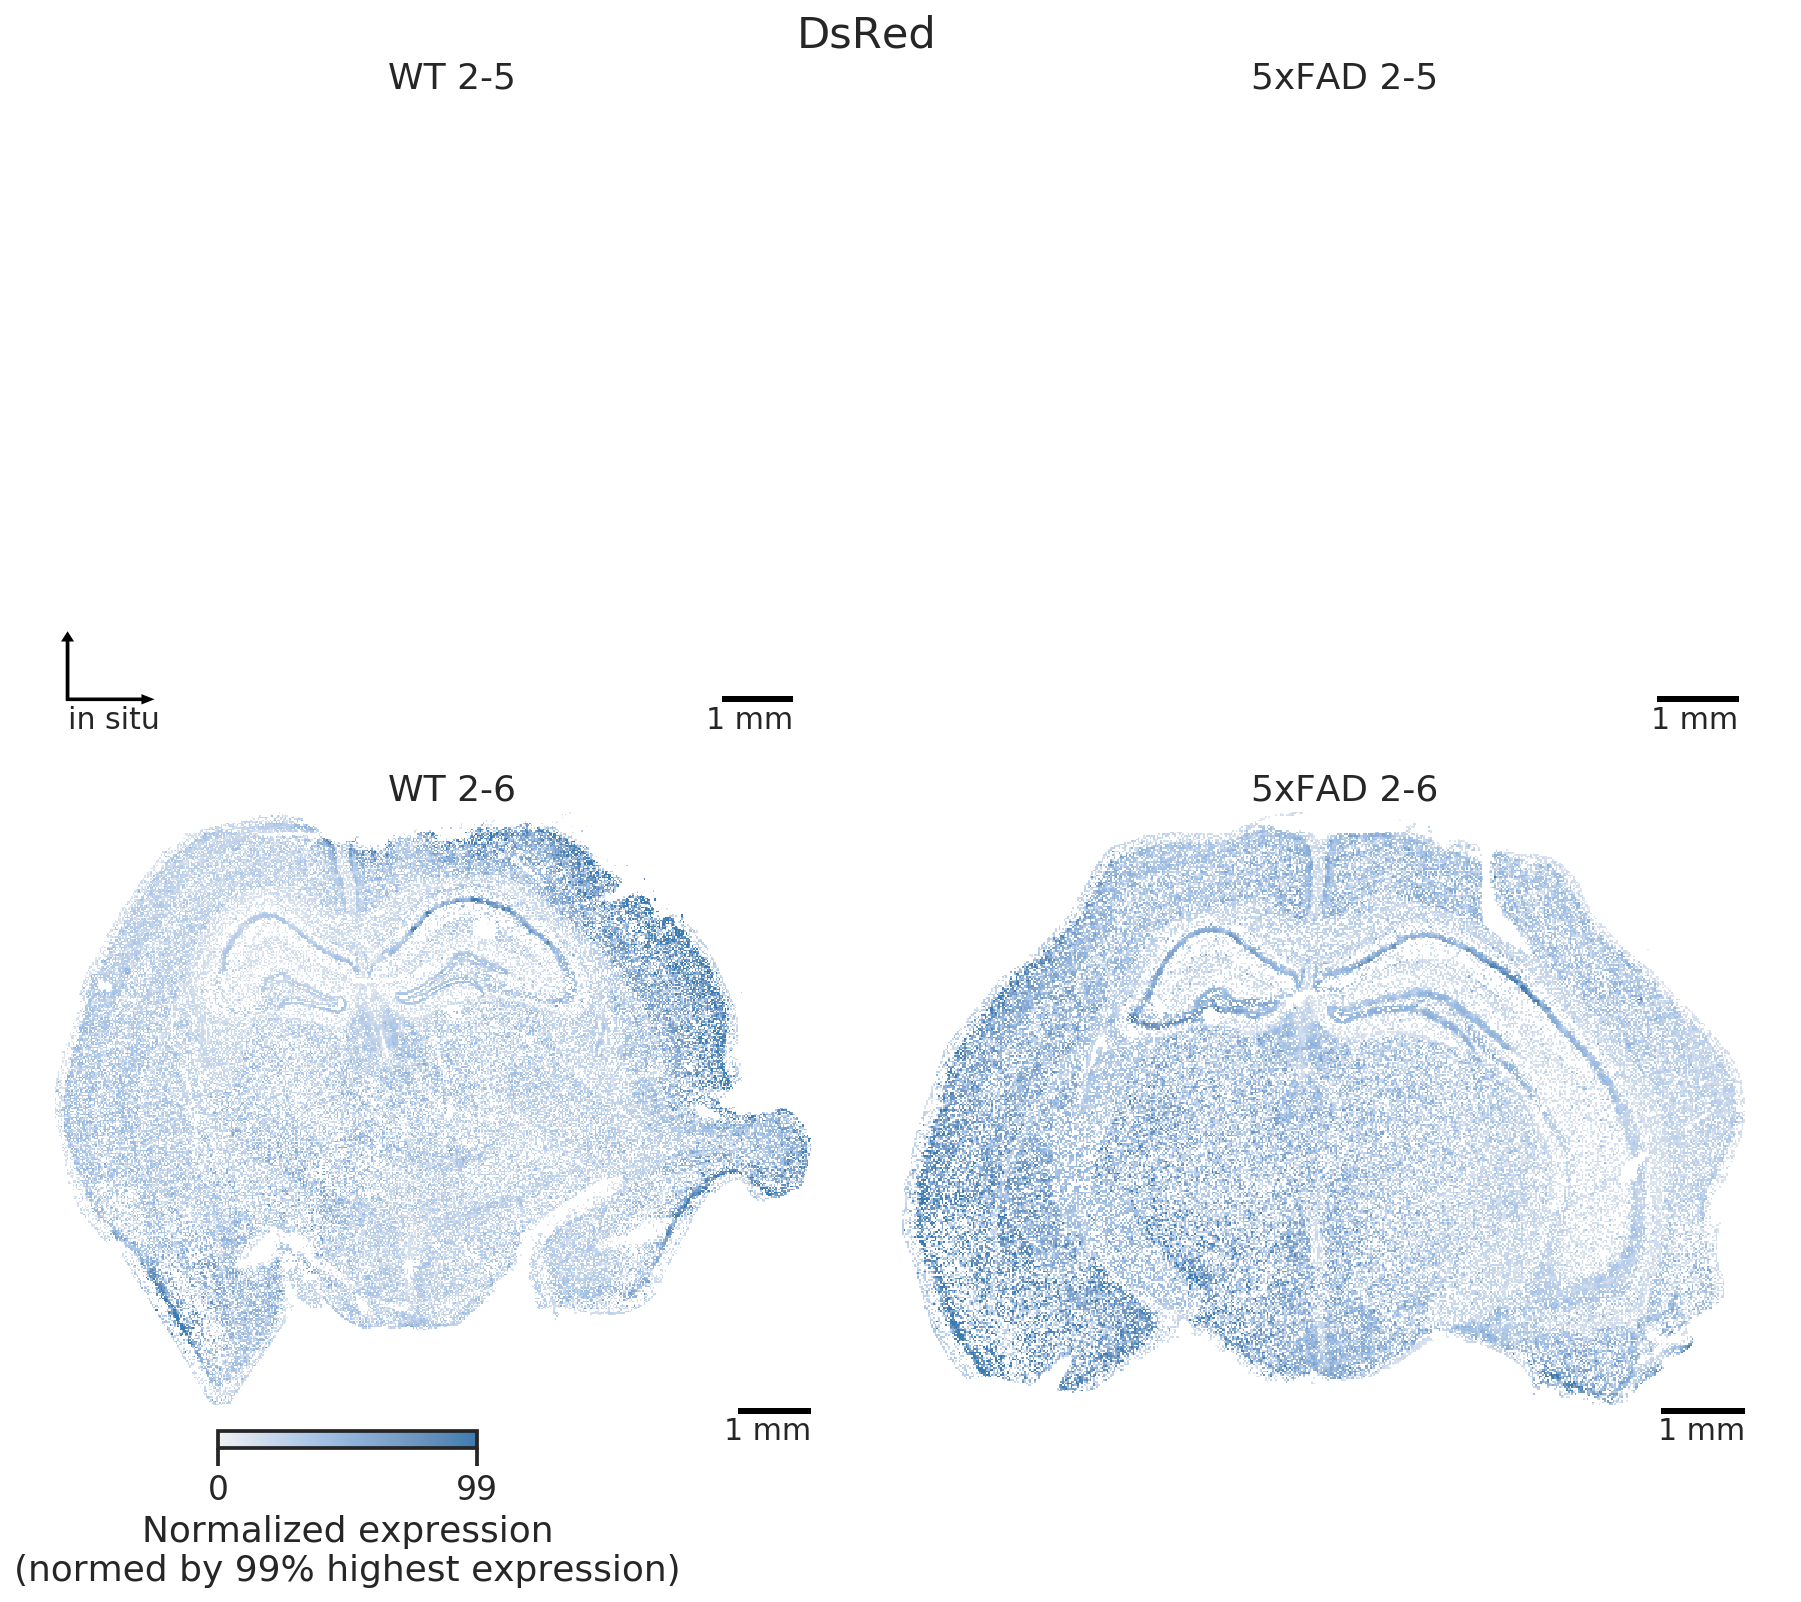

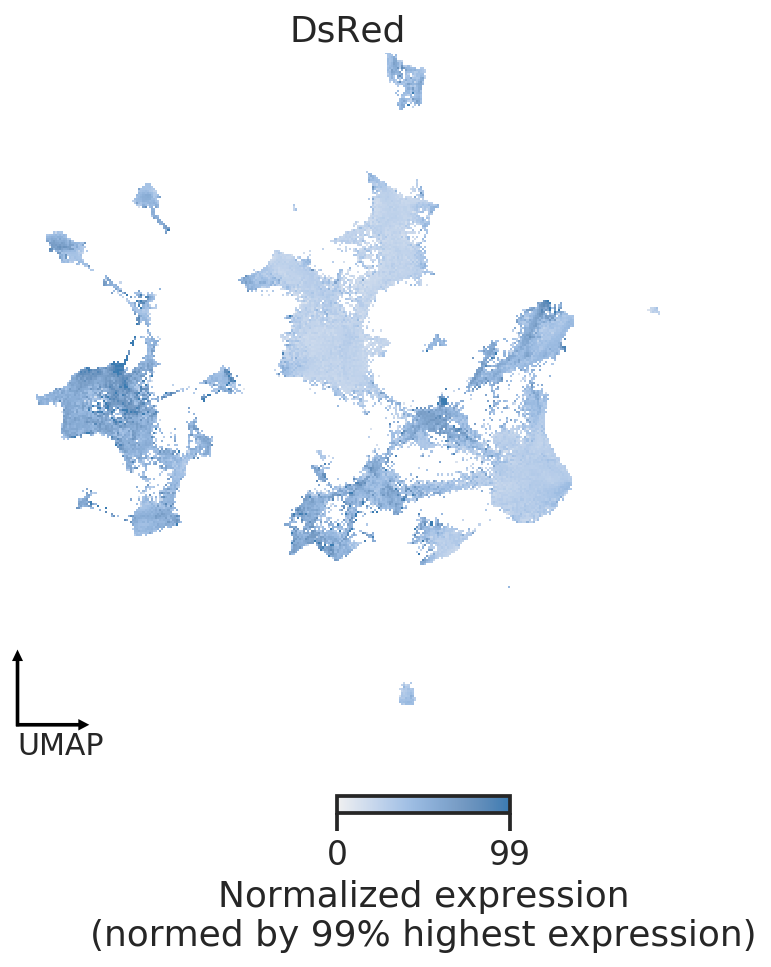

  0%|          | 0/2 [00:06<?, ?it/s]

../figures/2021-06-08_AD_mouse_dsred_umap_DsRed.pdf


In [13]:
# run genes view
selected_genes = ['DsRed', 'Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("insitu_"+gene+".pdf")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
        samples_annot=samples_annot,
        nx=2, ny=2, figsize=(9*2,6*2),
#         close=True,
#         output='', 
        output=output, 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("umap_"+gene+".pdf")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
        output=output,
        close=False,
#         close=True,
        )
    print(output)
    break

### Run cluster viz (combined)

In [18]:
# # selected clusters (preserve colors)
# clstcolors_obj = powerplot.CategoricalColors(
#     clusters)
# colors = clstcolors_obj.colors

# selected_clusters = ['C15', 'C16', 'C19']
# selected_colors = [
#     color if label in selected_clusters else 'lightgray'
#     for color, label in zip(colors, clusters)
# ]
# selected_clstcolors_obj = powerplot.CategoricalColors(
#     clusters, selected_colors,
# )

clusters = np.sort(thedata['cluster_cat'].unique())

# selected clusters (not preserve colors)
colors = ['lightgray']*len(clusters)
selected_clusters = ['C15', 'C16', 'C19']
selected_colors = powerplot.CategoricalColors(selected_clusters).colors
for i, clst in enumerate(selected_clusters):
    idx = np.where(clusters==clst)[0][0]
    colors[idx] = selected_colors[i]
selected_clstcolors_obj = powerplot.CategoricalColors(clusters, colors)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


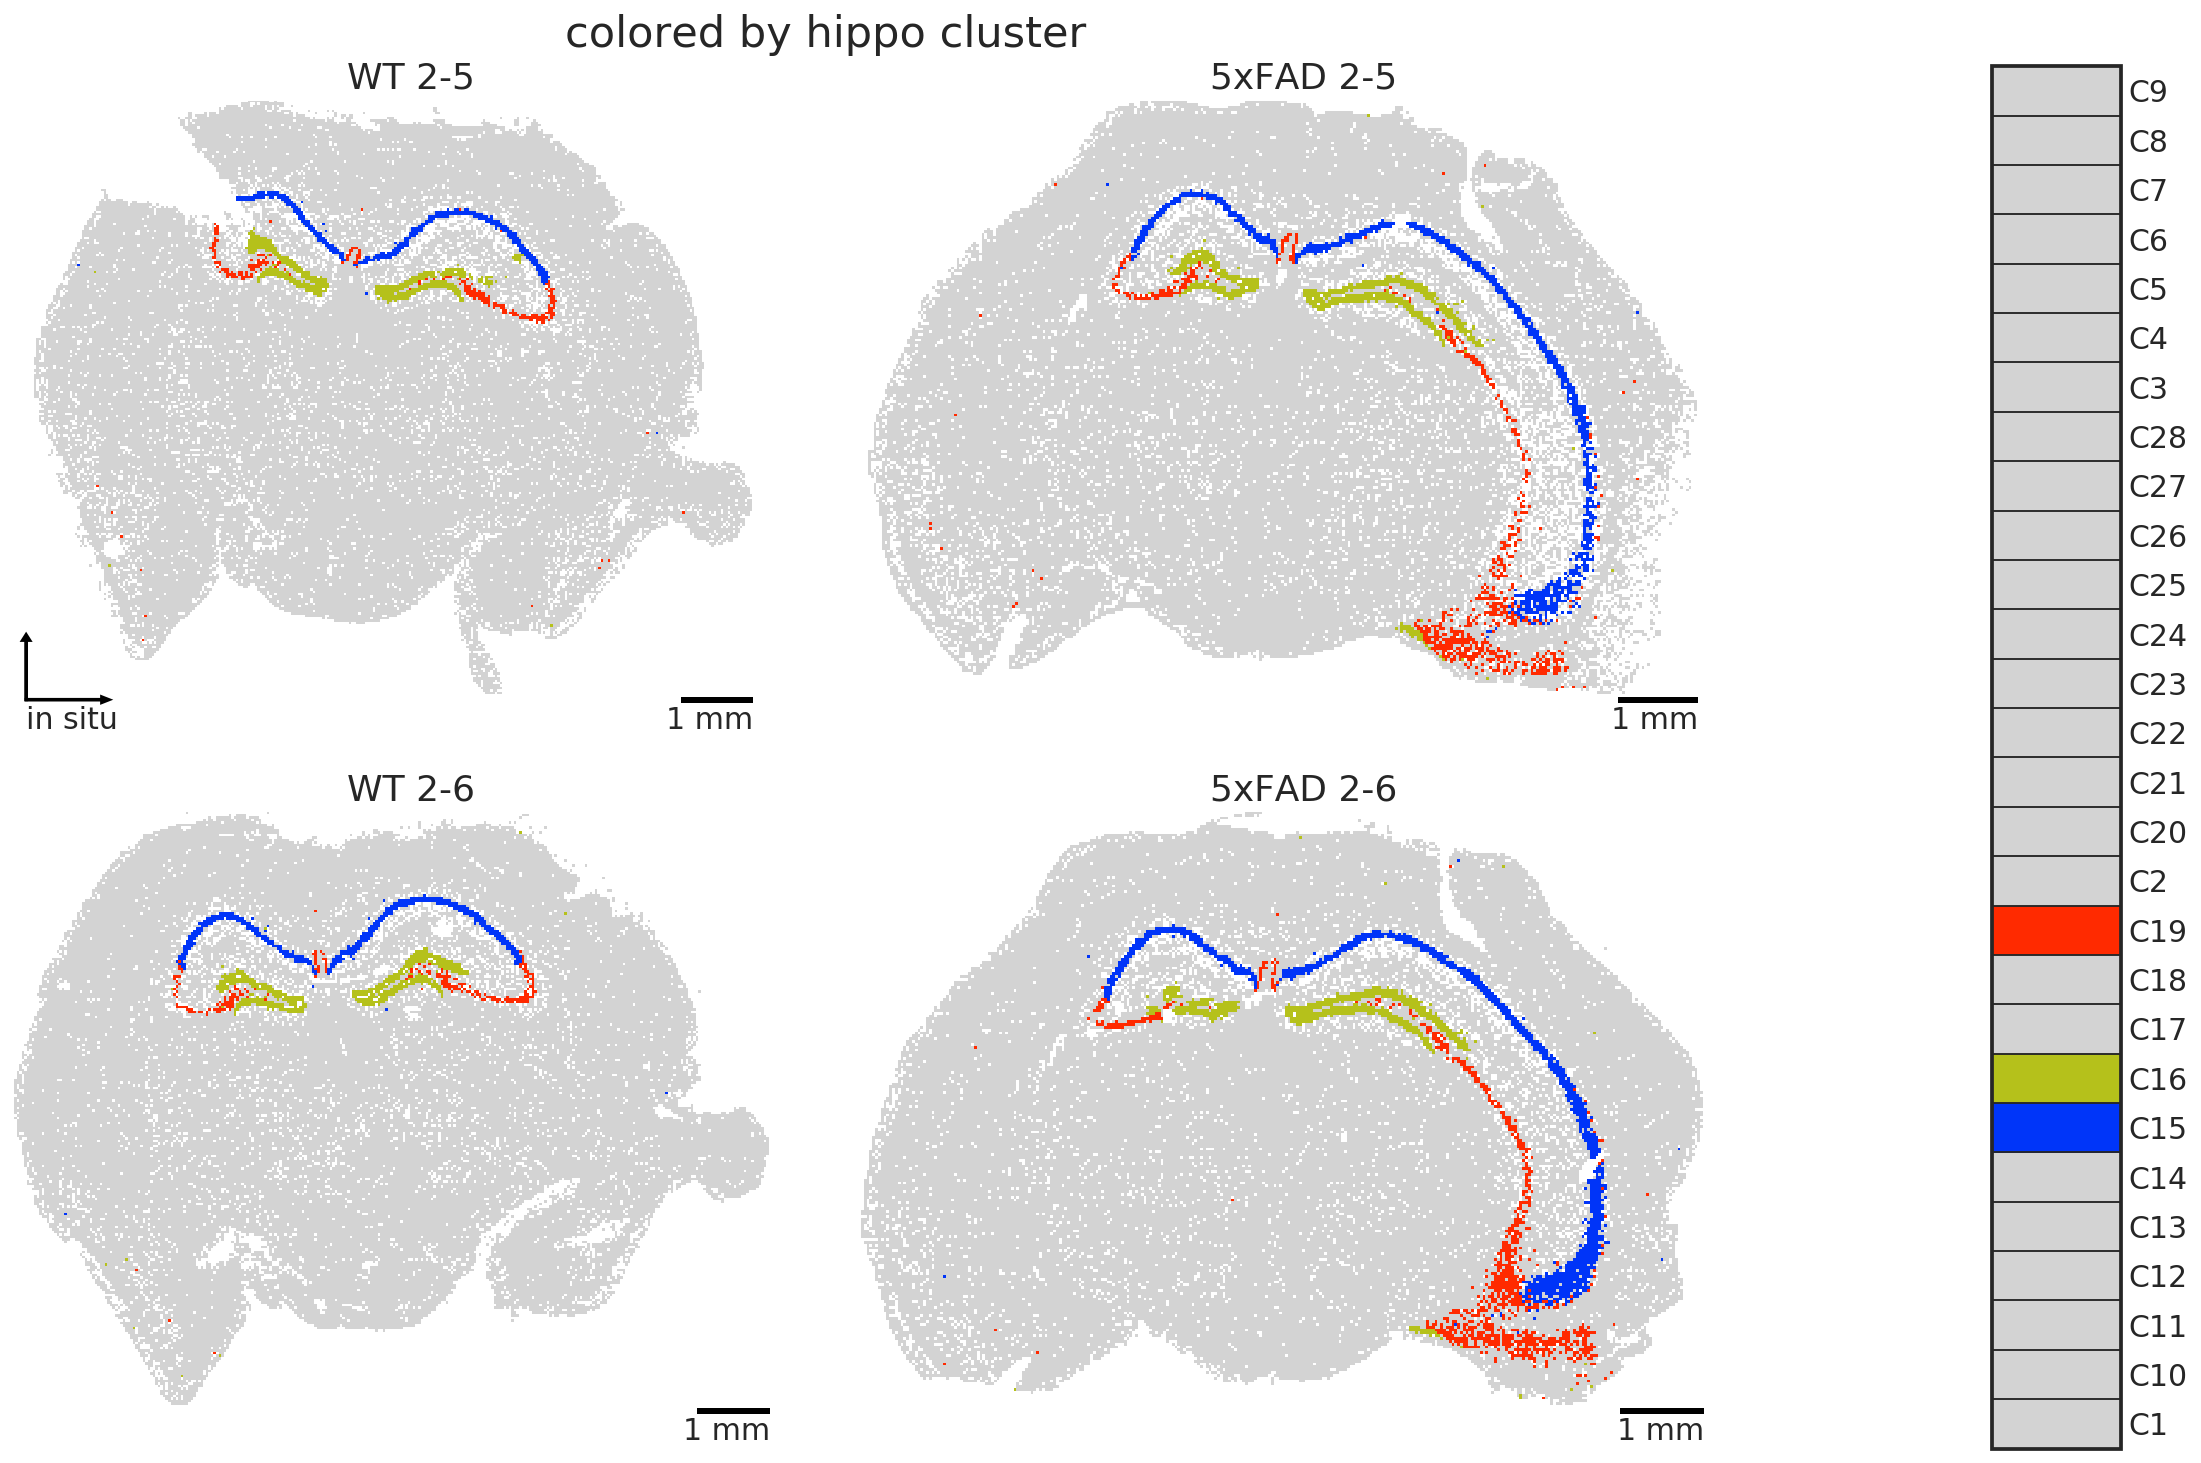

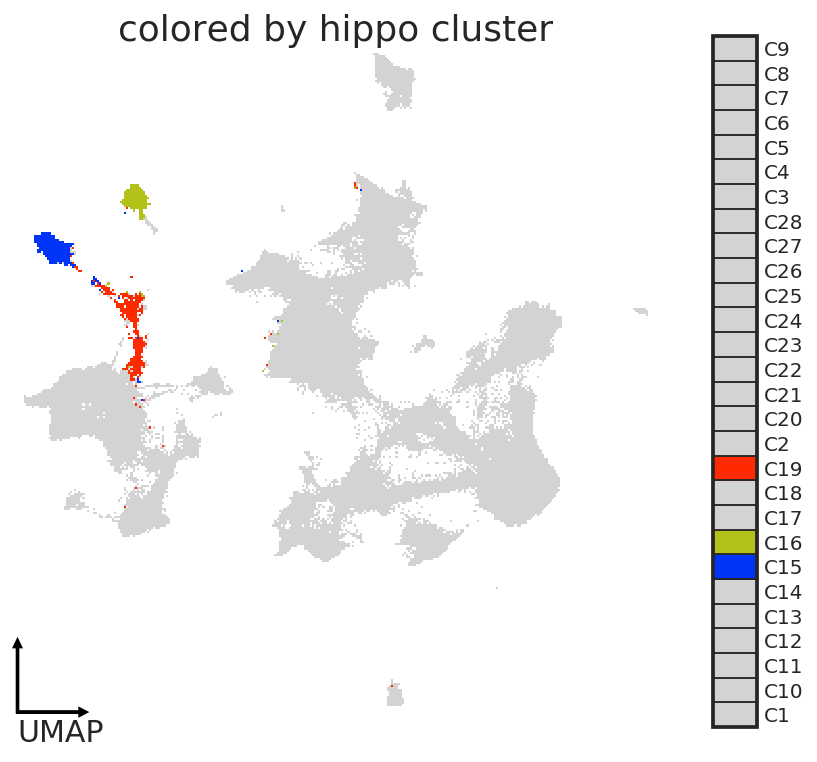

In [19]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by hippo cluster' 
output = figures.format("insitu_hippoclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    selected_clstcolors_obj,
    suptitle=suptitle,
    samples_annot=samples_annot,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by hippo cluster' 
output = figures.format("umap_hippoclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    selected_clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

# barplots -- number of cells for each clusters

## all gene analyses
- WT vs 5xFAD (2), cell types (N), replicates (2)
- get an heatmap - Ngenes * 4Ncelltypes 

In [20]:
# select hemi-brain sections
thesample = 'Xulab_2_6_region_0'
filter_cond = (
#     (
#       ((thedatagmat['sample'] == 'Xulab_2_5_region_0') & (thedatagmat['x'] > 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_5_region_1') & (thedatagmat['x'] < 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_6_region_0') & (thedatagmat['x'] < 0))
#     | ((thedatagmat['sample'] == 'Xulab_2_6_region_1') & (thedatagmat['x'] < 0))
#     )
#     & 
    (~thedatagmat['DsRed'].isnull())
    & (thedatagmat['sample'] == thesample)
)

# selecteddata
thedatagmat['sample_name'] = thedatagmat['sample'].apply(lambda x: samples_annot[x])
selecteddata = thedatagmat[filter_cond].copy()

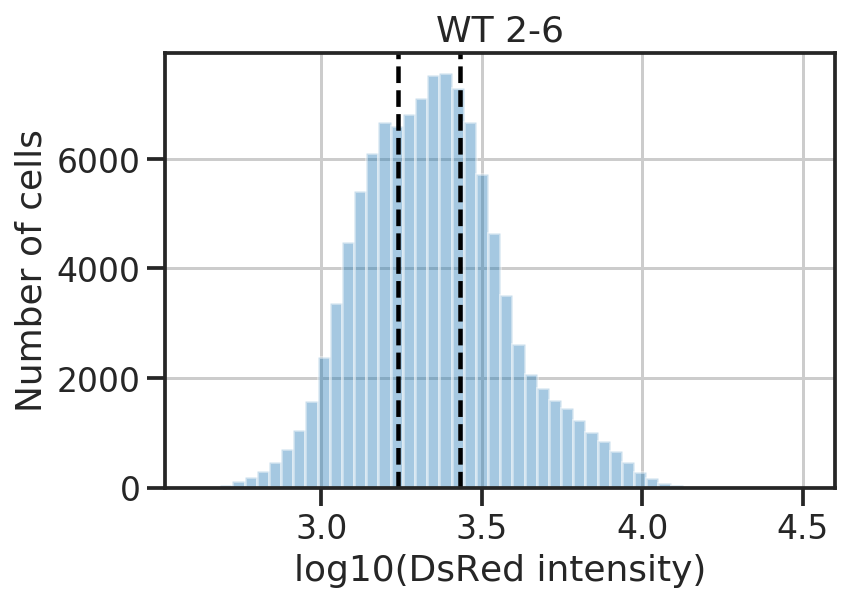

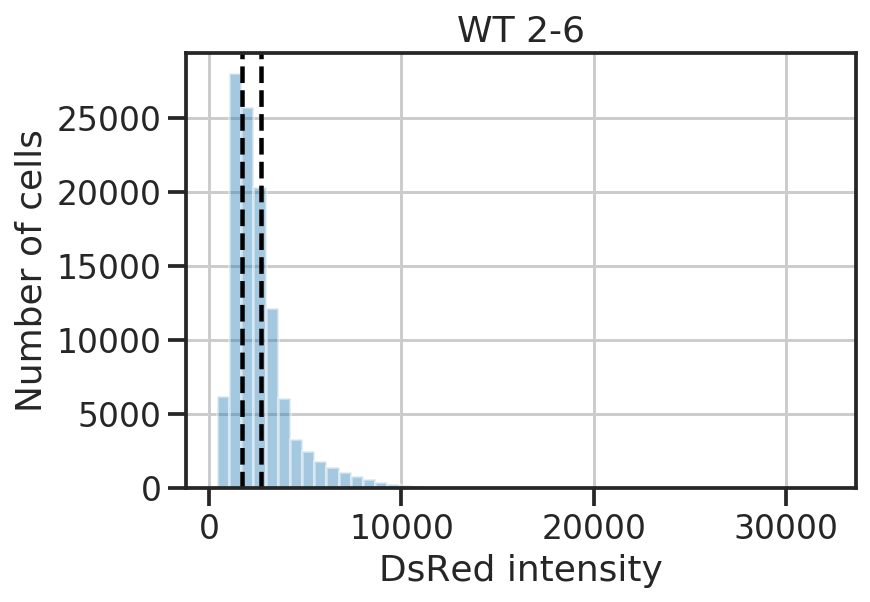

In [21]:
data = selecteddata
x = 'DsRed'
dsred_pth = 80

values = np.log10(data[x])
fig, ax = plt.subplots()
sns.distplot(values, kde=False, ax=ax)
ax.axvline(np.percentile(values, 100/3), color='k', linestyle='--')
ax.axvline(np.percentile(values, 100/3*2), color='k', linestyle='--')
# ax.set_xscale('log')
ax.set_xlabel("log10({} intensity)".format(x))
ax.set_ylabel('Number of cells')
ax.set_title(samples_annot[thesample])
plt.show()


values = data[x]
fig, ax = plt.subplots()
sns.distplot(values, kde=False, ax=ax)
ax.axvline(np.percentile(values, 100/3), color='k', linestyle='--')
ax.axvline(np.percentile(values, 100/3*2), color='k', linestyle='--')
# ax.set_xscale('log')
ax.set_xlabel("{} intensity".format(x))
ax.set_ylabel('Number of cells')
ax.set_title(samples_annot[thesample])
plt.show()

In [22]:
selecteddata['DsRed_cat'] = pd.qcut(selecteddata['DsRed'], 3, labels=['low DsRed', 'moderate DsRed', 'high DsRed'])
selecteddata['DsRed_cat']

cell
11889725947908115189174574382566979077      low DsRed
188917926440714793772346102514908676243     low DsRed
196292221171325337439317852691387045923     low DsRed
217336296600424055856444818081846312267     low DsRed
319652409737626495737200360475936228770     low DsRed
                                              ...    
34075153521343365091179009840026597084      low DsRed
91507581758406926897626666577016132341     high DsRed
174998125559141434507473700641877501578    high DsRed
188360346585778998064722013688823790884    high DsRed
87069034024545867844488266804632078214     high DsRed
Name: DsRed_cat, Length: 110815, dtype: category
Categories (3, object): ['low DsRed' < 'moderate DsRed' < 'high DsRed']

In [23]:
sizemat = selecteddata.groupby(['cluster', 'DsRed_cat']).size().unstack() #.fillna(0).astype(int) #.stack()

hqclusters = sizemat[~((sizemat < 20).sum(axis=1) > 0)].index.values
print(len(hqclusters), len(clusters))

selecteddata = selecteddata[selecteddata['cluster'].isin(hqclusters)]
print(selecteddata.shape)

27 28
(110212, 190)


In [24]:

# mean, std, n, zscore 
gmat_mean = selecteddata.groupby(['cluster', 'DsRed_cat']).mean()[genes]
gmat_std = selecteddata.groupby(['cluster', 'DsRed_cat']).std()[genes]
gmat_n = selecteddata.groupby(['cluster', 'DsRed_cat']).count()[genes]
gmat_meanz = (gmat_mean - gmat_mean.mean())/gmat_mean.std()

# celltypes
celltypes = gmat_mean.index.levels[0].values

print(thedatagmat.shape, selecteddata.shape)
print(gmat_mean.shape, gmat_std.shape, gmat_n.shape, gmat_meanz.shape)

(450001, 189) (110212, 190)
(81, 150) (81, 150) (81, 150) (81, 150)


In [25]:
# mean diff and statistical significant diff

rescale = np.log(10)/np.log(2)

ctrl, case = 'low DsRed', 'high DsRed'
query_ctrl = 'DsRed_cat == "{}"'.format(ctrl)
query_case = 'DsRed_cat == "{}"'.format(case)
diff1 = (gmat_mean.query(query_case).droplevel(level=1)
         - gmat_mean.query(query_ctrl).droplevel(level=1)
        ).loc[celltypes]*rescale
diff1['slice'] = "high vs. low DsRed"
diff1 = diff1.set_index('slice', append=True)

ctrl, case = 'moderate DsRed', 'high DsRed'
query_ctrl = 'DsRed_cat == "{}"'.format(ctrl)
query_case = 'DsRed_cat == "{}"'.format(case)
diff2 = (gmat_mean.query(query_case).droplevel(level=1)
         - gmat_mean.query(query_ctrl).droplevel(level=1)
        ).loc[celltypes]*rescale
diff2['slice'] = "high vs. moderate DsRed"
diff2 = diff2.set_index('slice', append=True)

diffmat = pd.concat([diff1, diff2]).sort_index(level=0)
print(diffmat.shape)

# sig diff
alpha = 0.05

ctrl, case = 'low DsRed', 'high DsRed'
query_ctrl = 'DsRed_cat == "{}"'.format(ctrl)
query_case = 'DsRed_cat == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "high vs. low DsRed"
q = q.set_index('slice', append=True)
rej = q<alpha

q1 = q
rej1 = rej

ctrl, case = 'moderate DsRed', 'high DsRed'
query_ctrl = 'DsRed_cat == "{}"'.format(ctrl)
query_case = 'DsRed_cat == "{}"'.format(case)
t, p = stats.ttest_ind_from_stats(
    gmat_mean.query(query_ctrl).loc[celltypes].values,
    gmat_std.query(query_ctrl).loc[celltypes].values,
    gmat_n.query(query_ctrl).loc[celltypes].values,
    gmat_mean.query(query_case).loc[celltypes].values,
    gmat_std.query(query_case).loc[celltypes].values,
    gmat_n.query(query_case).loc[celltypes].values,
)
p[np.isnan(p)] = 1
q = utils.get_fdr(p.reshape(-1)).reshape(p.shape)
q = pd.DataFrame(q, index=celltypes, columns=genes)
q['slice'] = "high vs. moderate DsRed"
q = q.set_index('slice', append=True)
rej = q<alpha

q2 = q
rej2 = rej

qmat = pd.concat([q1, q2]).sort_index(level=0)
rejmat = pd.concat([rej1, rej2]).sort_index(level=0)
# rejmat

(54, 150)


../figures/2021-06-08_AD_mouse_dsred_gene_by_clusters_separate_DsRed_levels.pdf


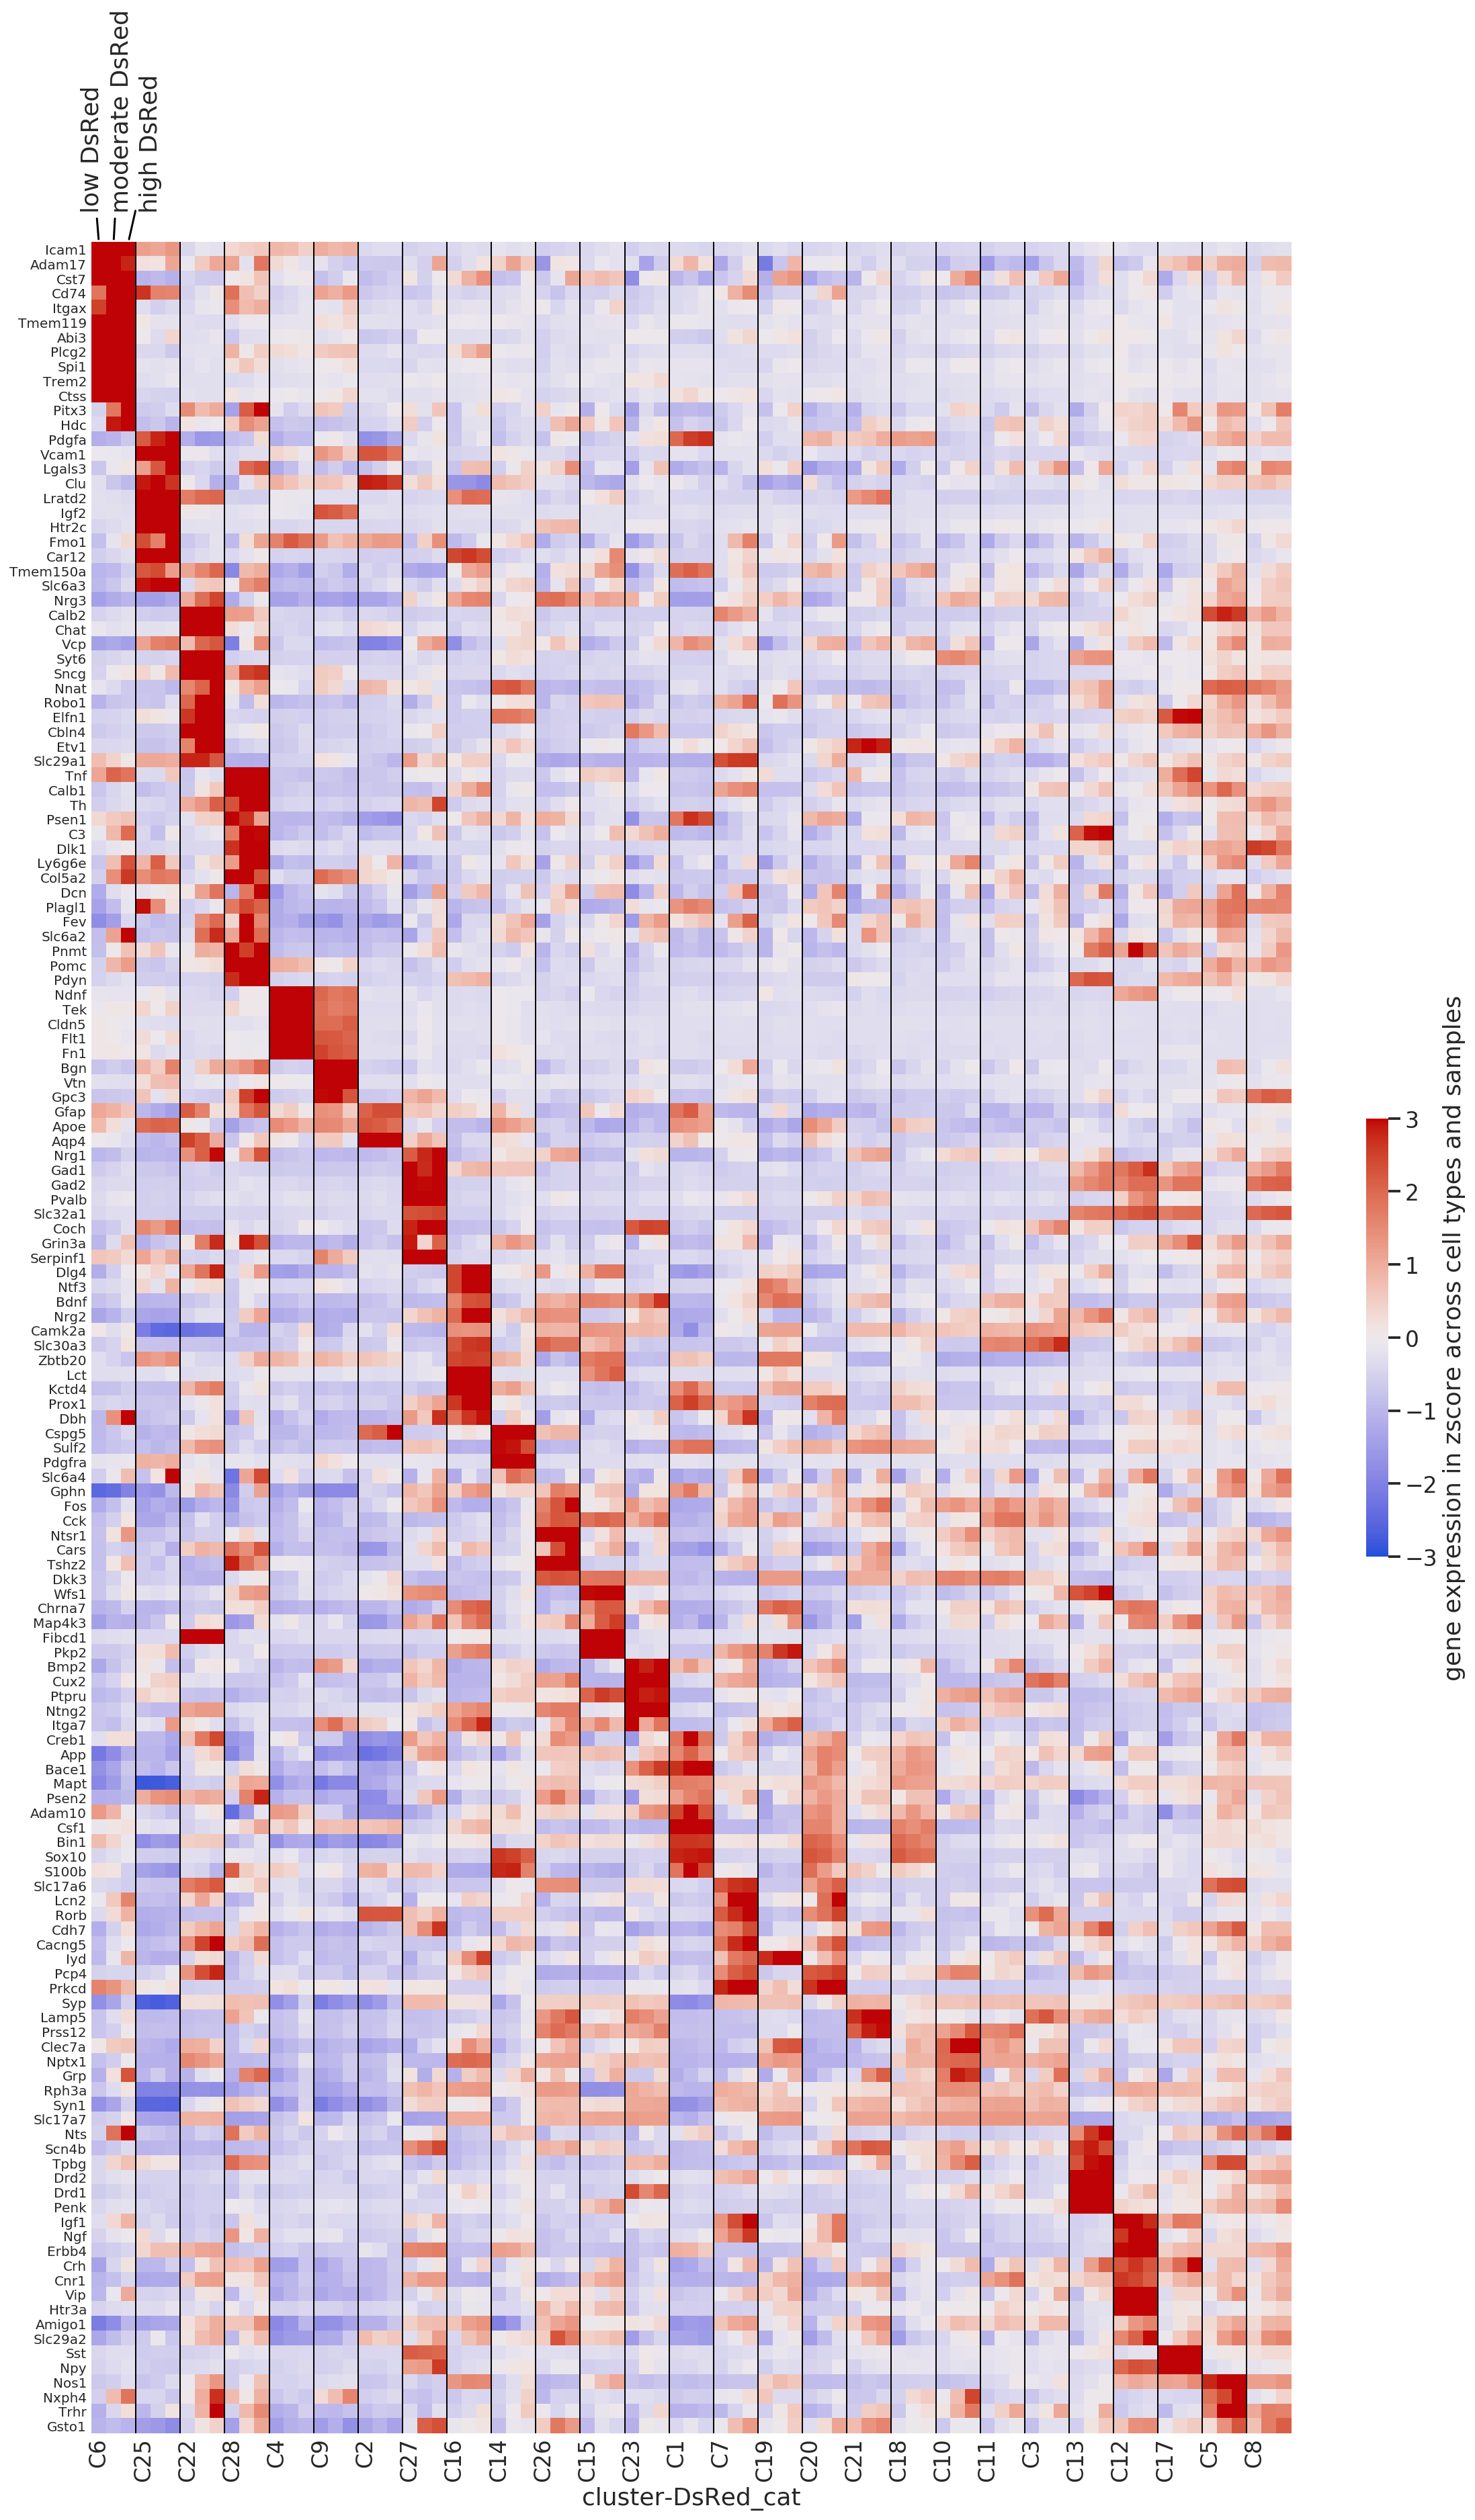

In [26]:
output = figures.format("gene_by_clusters_separate_DsRed_levels.pdf")

nperclst = 3

heatmat = gmat_meanz.T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([nperclst*col+np.arange(nperclst) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([nperclst*col+np.arange(nperclst) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(nperclst): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.vlines(np.arange(0, ncol, nperclst)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

cluster_orders = col_order_reduced

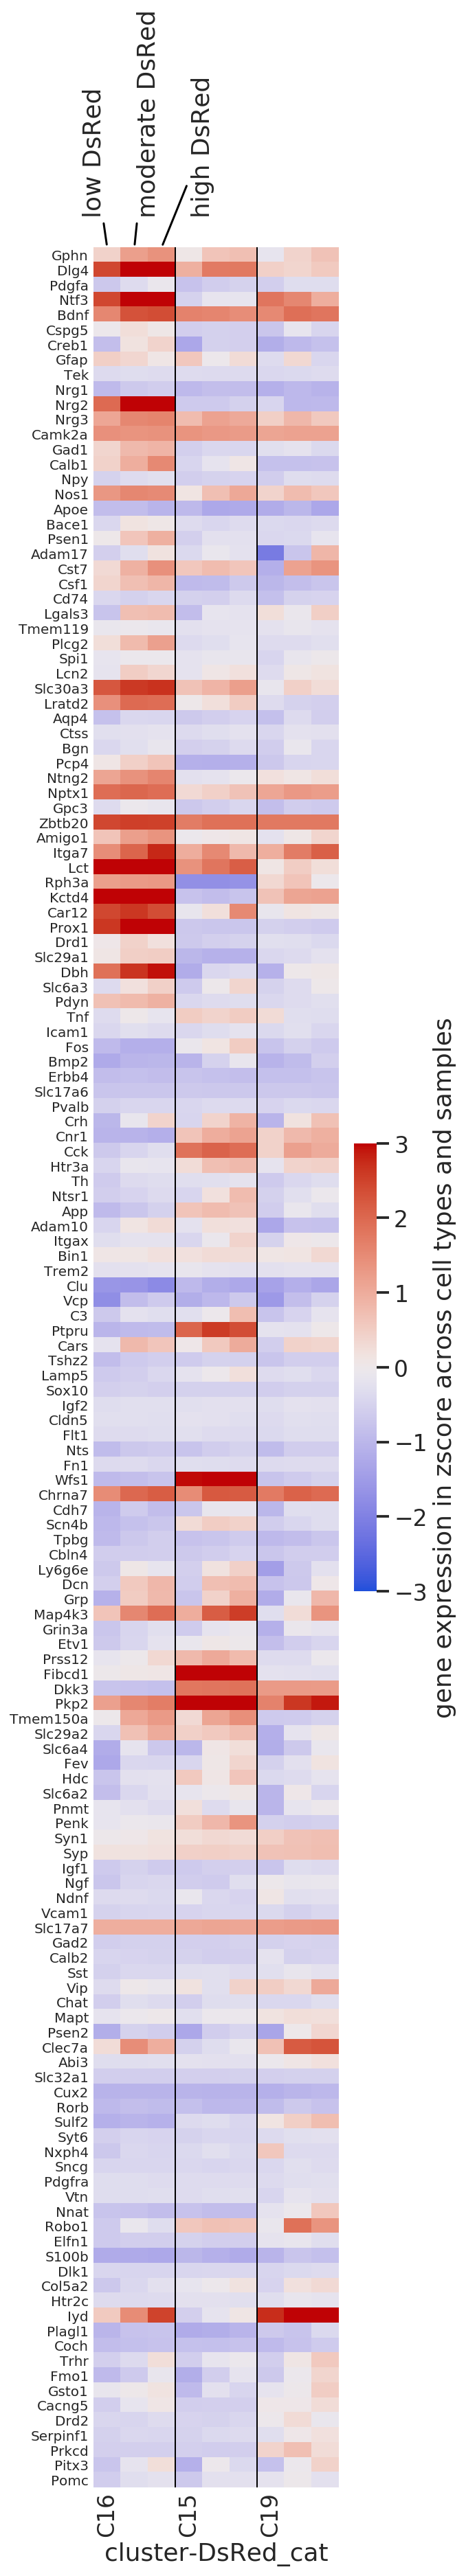

In [27]:

nperclst = 3

heatmat = gmat_meanz.loc[selected_clusters].T

heatmat_reduced = heatmat.mean(level=0, axis=1)
nrow, ncol = heatmat.shape

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([nperclst*col+np.arange(nperclst) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([nperclst*col+np.arange(nperclst) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat_reduced.iloc[:,col_order_reduced].values)

fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell types and samples'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(nperclst): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.vlines(np.arange(0, ncol, nperclst)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

# utils.savefig(fig, output)
# print(output)
plt.show()

../figures/2021-06-08_AD_mouse_dsred_gene_diff_DsRed.pdf


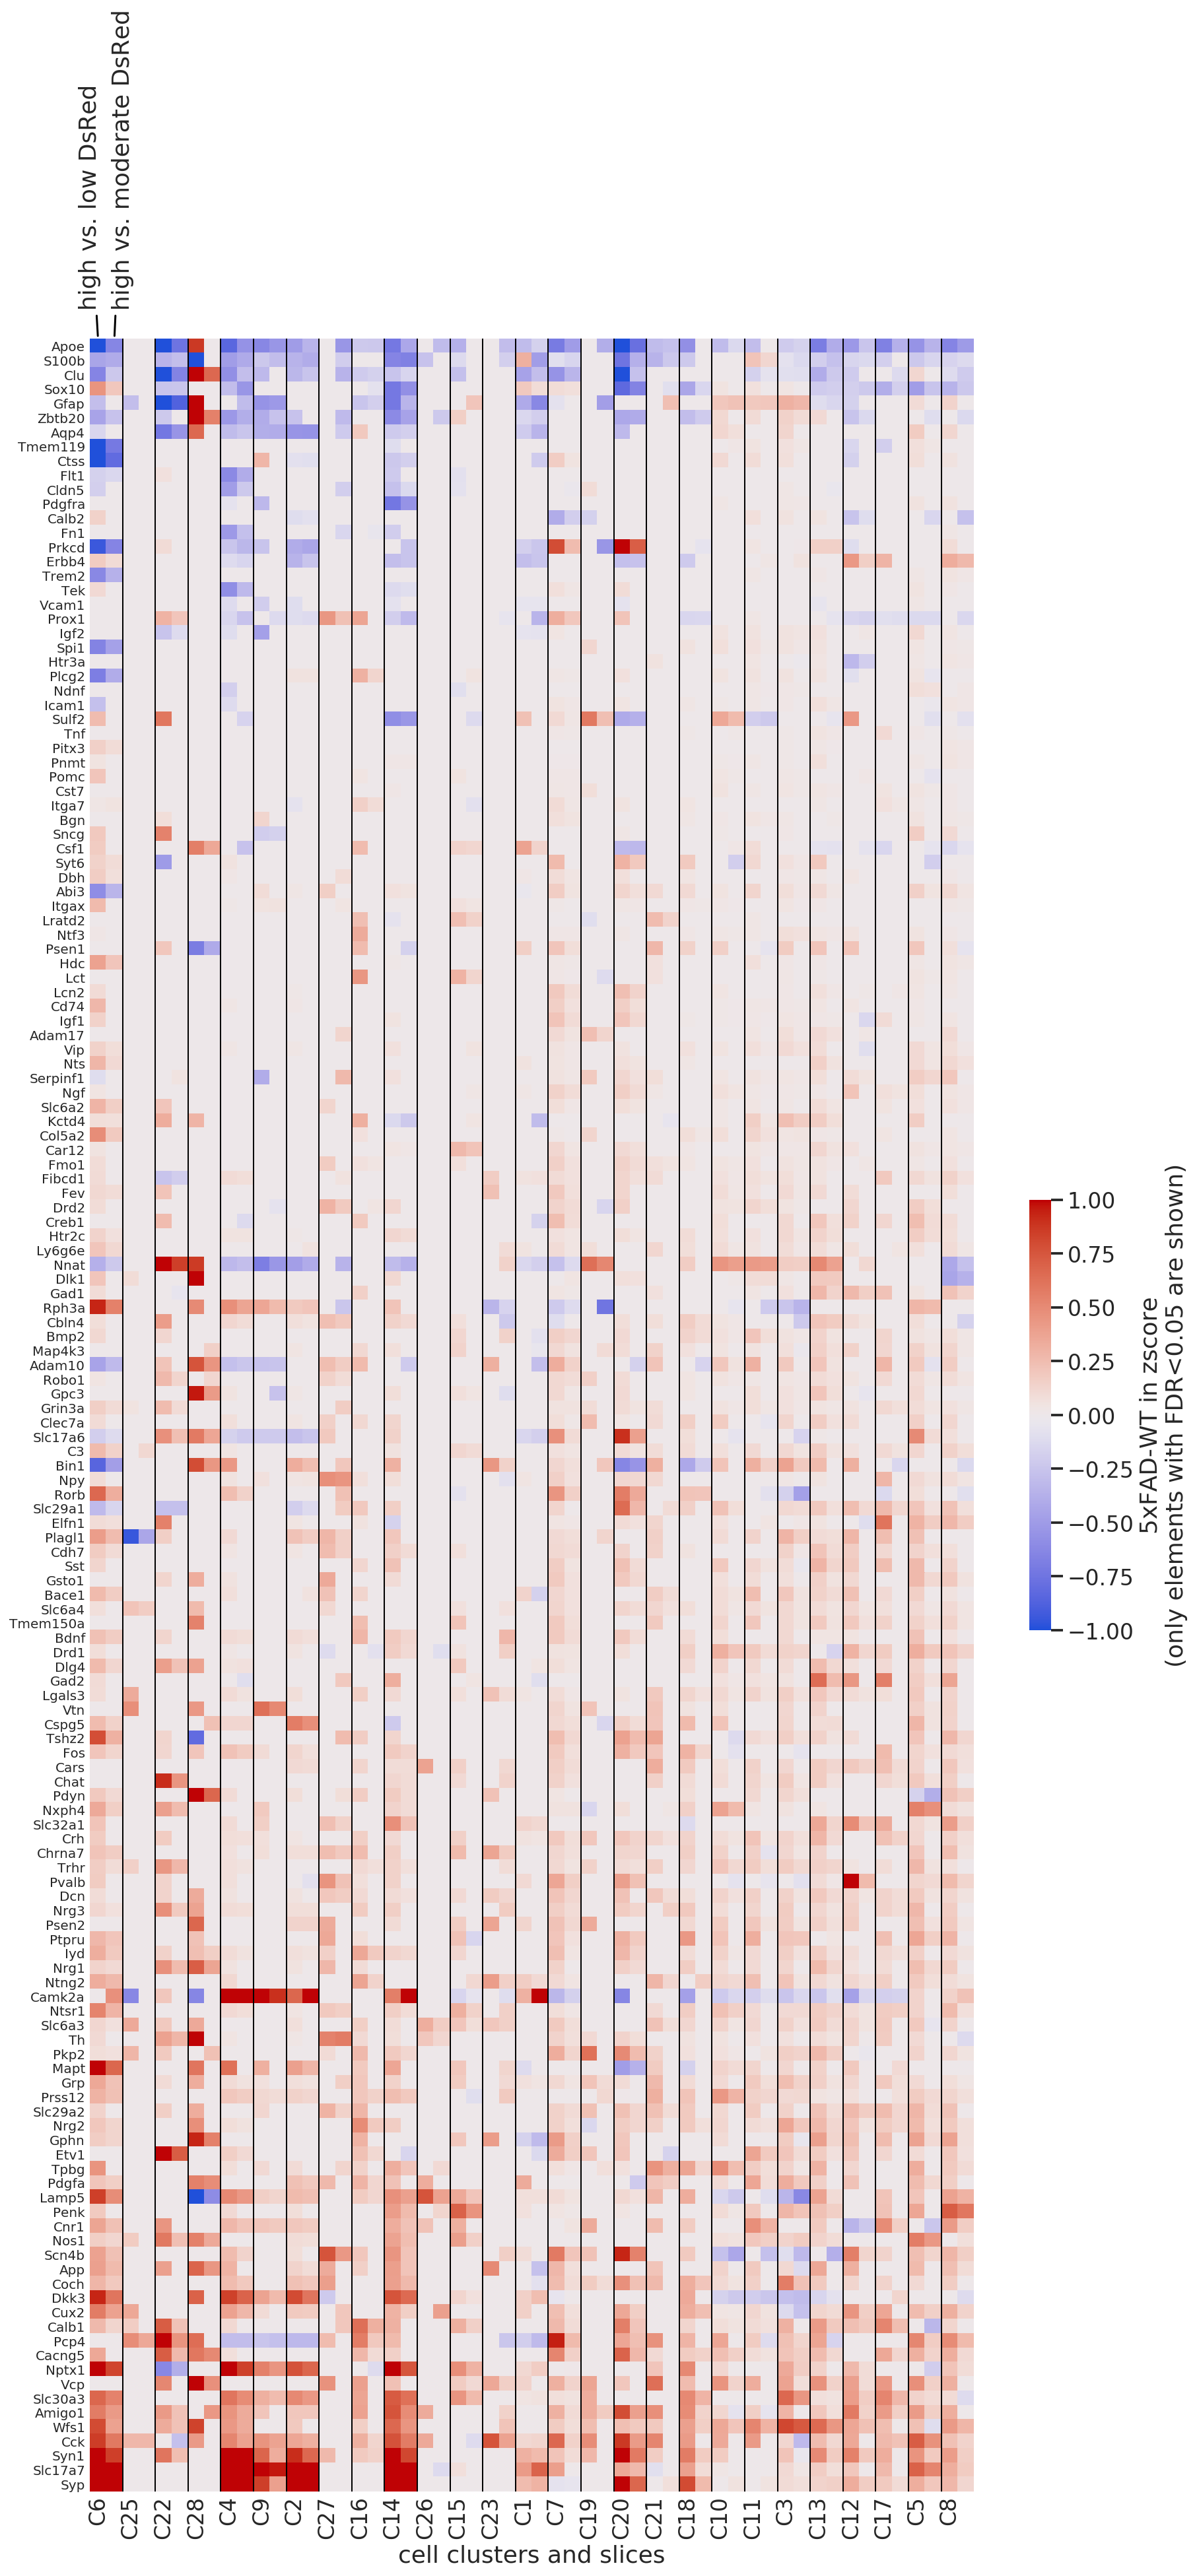

In [28]:
output = figures.format("gene_diff_DsRed.pdf")

heatmat = (rejmat*diffmat).T

nrow, ncol = heatmat.shape
heatmat_reduced = heatmat.mean(level=0, axis=1)

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([2*col+np.array([0,1,]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([2*col+np.array([0,1,]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,col_order_reduced].abs().values)

_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,cluster_orders].abs().values)

# order4
colidx_v4 = np.hstack([2*col+np.array([0,1,]) for col in cluster_orders])


# order5
rowidx_v5 = np.argsort(heatmat.sum(axis=1))



fig, ax = plt.subplots(figsize=(15, 30))
sns.heatmap(
    heatmat.iloc[rowidx_v5, colidx_v4], 
#     heatmat.iloc[row_order, colidx_v4], 
#     heatmat.iloc[rowidx_v3, colidx_v4],
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
#     heatmat.iloc[rowidx_v3, col_order], 
#     heatmat,
    
    vmax=1, vmin=-1, 
    center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='5xFAD-WT in zscore\n(only elements with FDR<0.05 are shown)'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(2): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.set_xlabel('cell clusters and slices')
ax.vlines(np.arange(0, ncol, 2)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

../figures/2021-06-08_AD_mouse_dsred_gene_diff_DsRed_hippo.pdf


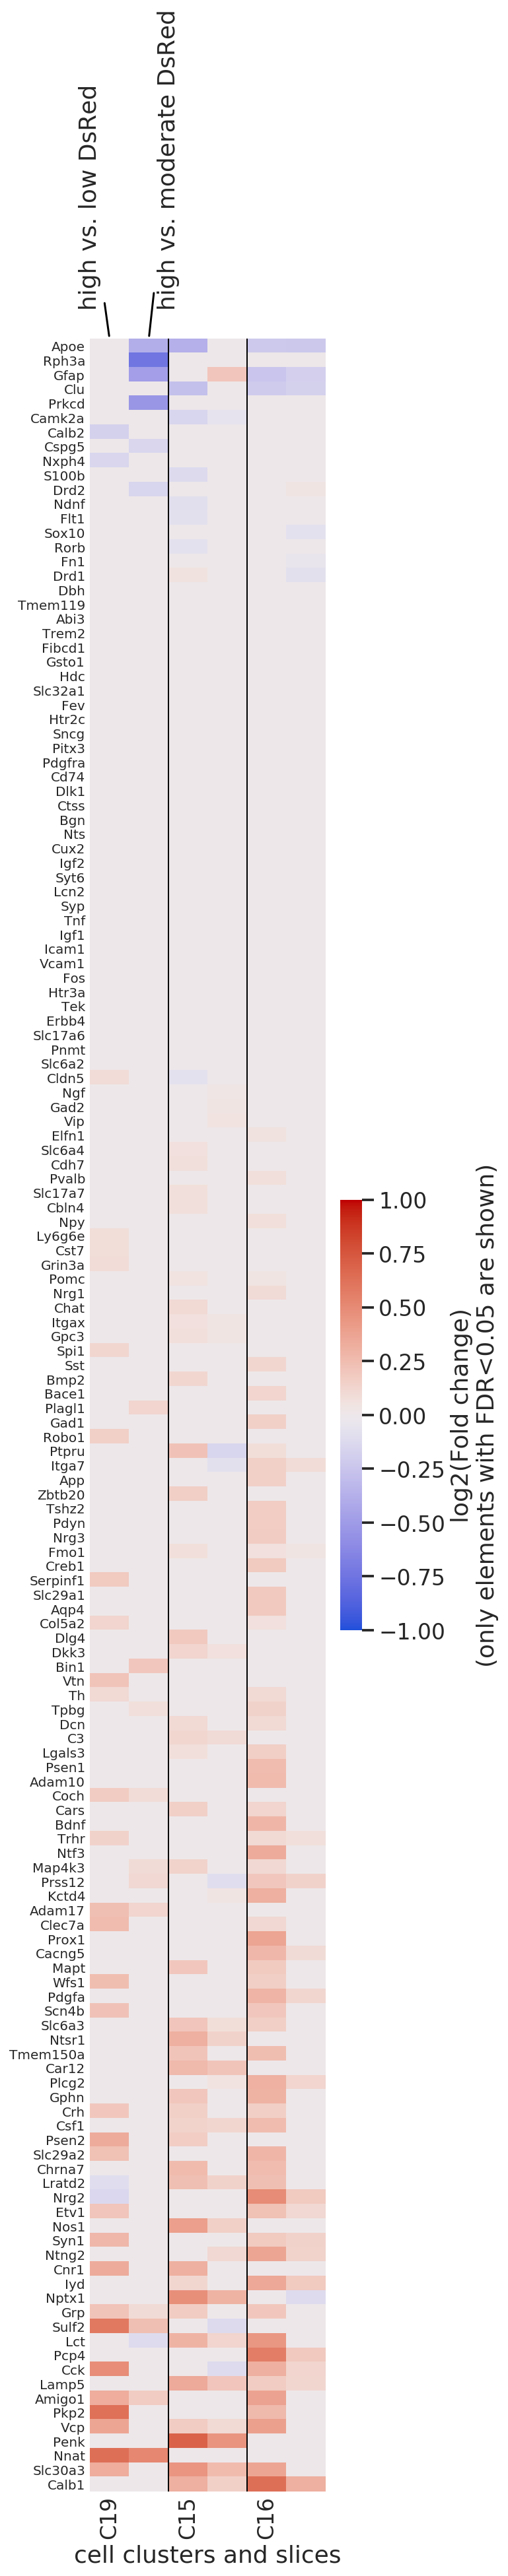

In [29]:
output = figures.format("gene_diff_DsRed_hippo.pdf")

heatmat = (rejmat*diffmat).loc[selected_clusters].T

nrow, ncol = heatmat.shape
heatmat_reduced = heatmat.mean(level=0, axis=1)

# order1 
_, rowidx, colidx_reduced = utils.diag_matrix(heatmat_reduced.values, threshold=1)
colidx = np.hstack([2*col+np.array([0,1,]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat_reduced.T) # by cluster; collapse slices
col_order = np.hstack([2*col+np.array([0,1,]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(
    heatmat_reduced.iloc[:,col_order_reduced].abs().values)

# # order4
# colidx_v4 = np.hstack([2*col+np.array([0,1,]) for col in cluster_orders])


# order5
rowidx_v5 = np.argsort(heatmat.sum(axis=1))



fig, ax = plt.subplots(figsize=(4, 30))
sns.heatmap(
    heatmat.iloc[rowidx_v5, col_order],
#     heatmat.iloc[rowidx_v5, colidx_v4], 
#     heatmat.iloc[row_order, colidx_v4], 
#     heatmat.iloc[rowidx_v3, colidx_v4],
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
#     heatmat.iloc[rowidx_v3, col_order], 
#     heatmat,
    
    vmax=1, vmin=-1, 
    center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='log2(Fold change)\n(only elements with FDR<0.05 are shown)'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(axis=u'both', which=u'both',length=0)

xtl = [tl.get_text() for tl in ax.get_xticklabels()]
xtl_part1 = [tl.split('-')[0] for tl in xtl]
xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
ax.set_xticklabels(xtl_simp)
for i in range(2): 
    ax.annotate(xtl_part2[i], 
                (i+0.5, 0), (2*i, -2), 
                arrowprops=dict(arrowstyle='-', color='black'), 
                va='bottom', 
                ha='center',
                rotation=90,
               )

ax.set_xlabel('cell clusters and slices')
ax.vlines(np.arange(0, ncol, 2)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

In [173]:
from sklearn import manifold

data = selecteddata.query('cluster_cat == "C15"').copy()
data['logDsRed'] = np.log10(data['DsRed']+1)
data['coords'] = -manifold.SpectralEmbedding(n_components=1, random_state=0).fit_transform(data[['x', 'y']])

In [174]:
data = data[(
    (data['x']>np.percentile(data['x'], 1))
  & (data['x']<np.percentile(data['x'], 99))
)]

data = data[(
    (data['y']>np.percentile(data['y'], 1))
  & (data['y']<np.percentile(data['y'], 99))
)]

nbins = 40
xbins = np.linspace(data['x'].min(), data['x'].max(), nbins)
data['xbin'] = pd.cut(data['x'], xbins)
data_mean = data.groupby(['xbin']).mean()

 33%|███▎      | 1/3 [00:00<00:00,  4.04it/s]

../figures/2021-06-08_AD_mouse_dsred_insitu_coords.pdf


 67%|██████▋   | 2/3 [00:00<00:00,  4.16it/s]

../figures/2021-06-08_AD_mouse_dsred_insitu_DsRed.pdf


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

../figures/2021-06-08_AD_mouse_dsred_insitu_logDsRed.pdf


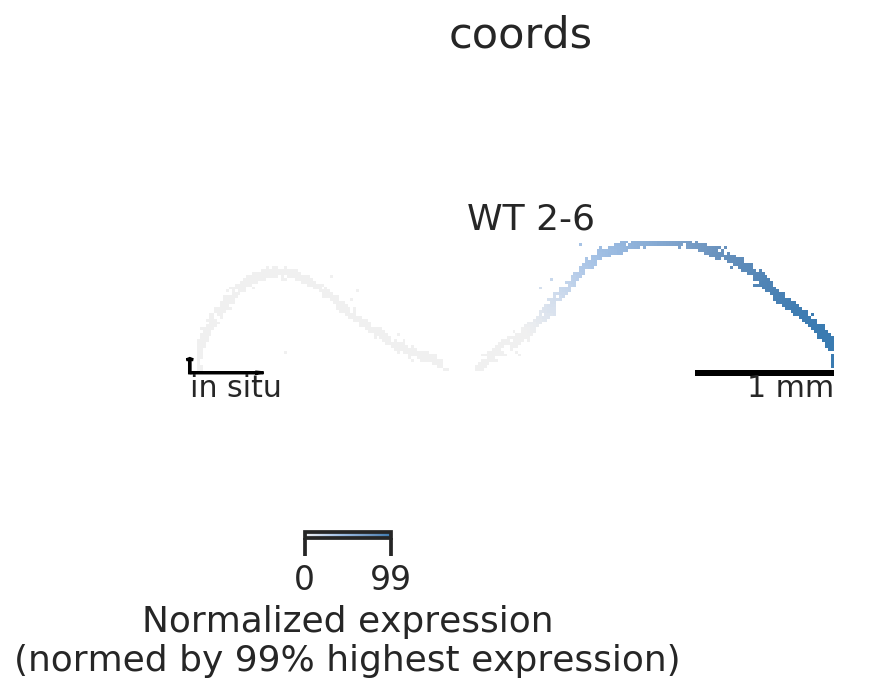

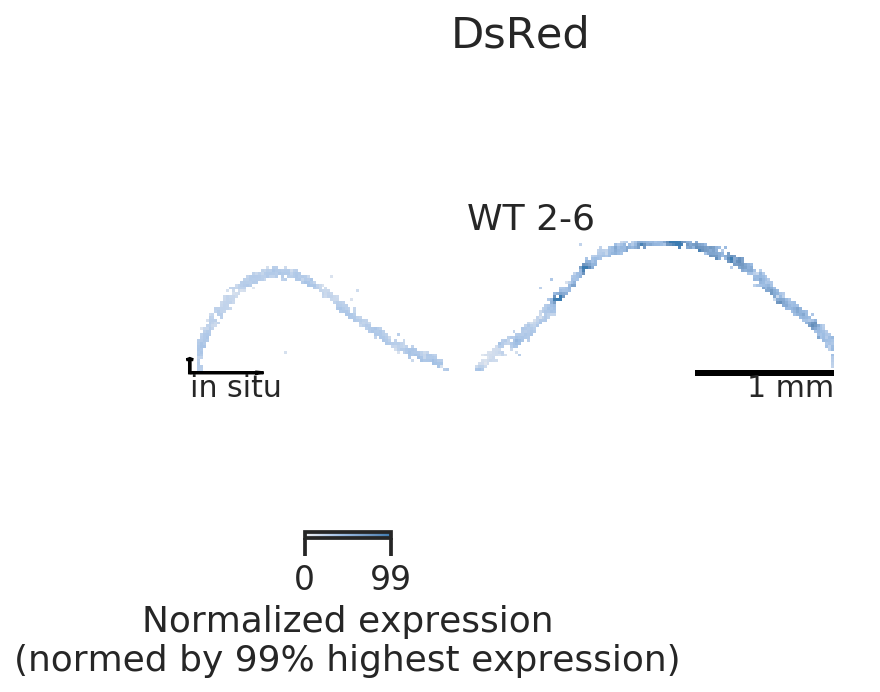

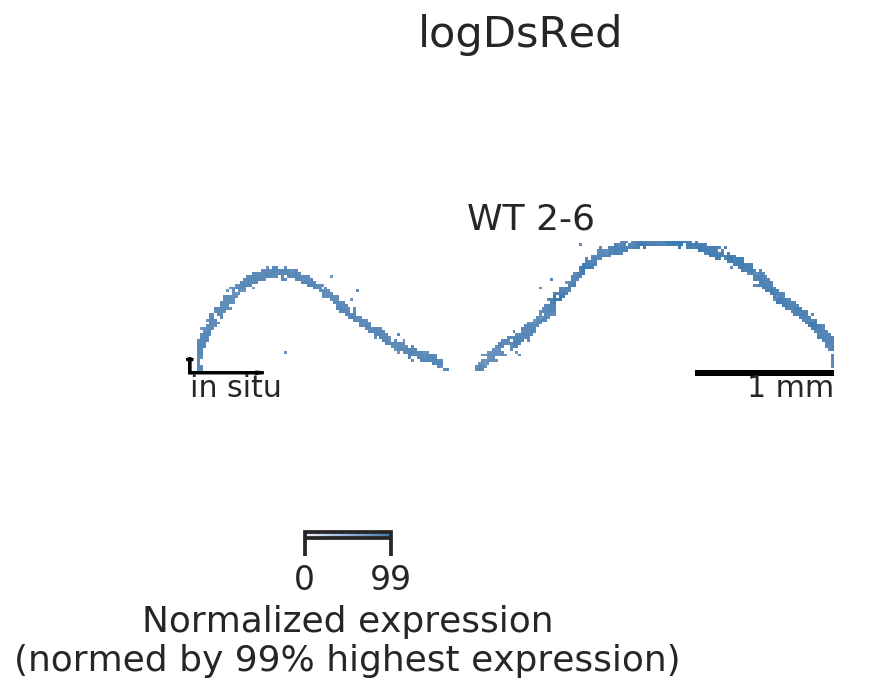

In [137]:
# run genes view
selected_genes = ['coords', 'DsRed', 'logDsRed']

for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    selected_samples = data['sample'].unique()
    output = figures.format("insitu_"+gene+".pdf")
    
    fig = fig_plot_gene_insitu_routine(
        data, selected_samples, x, y, hue, 
        samples_annot=samples_annot,
        nx=1, ny=1, figsize=(6*1,4*1),
#         close=True,
#         output='', 
        output=output, 
        close=False,
        )
    fig.suptitle(gene, y=1.01)
    
    print(output)

../figures/2021-06-08_AD_mouse_dsred_hippo_CA1_DsRed_level.pdf


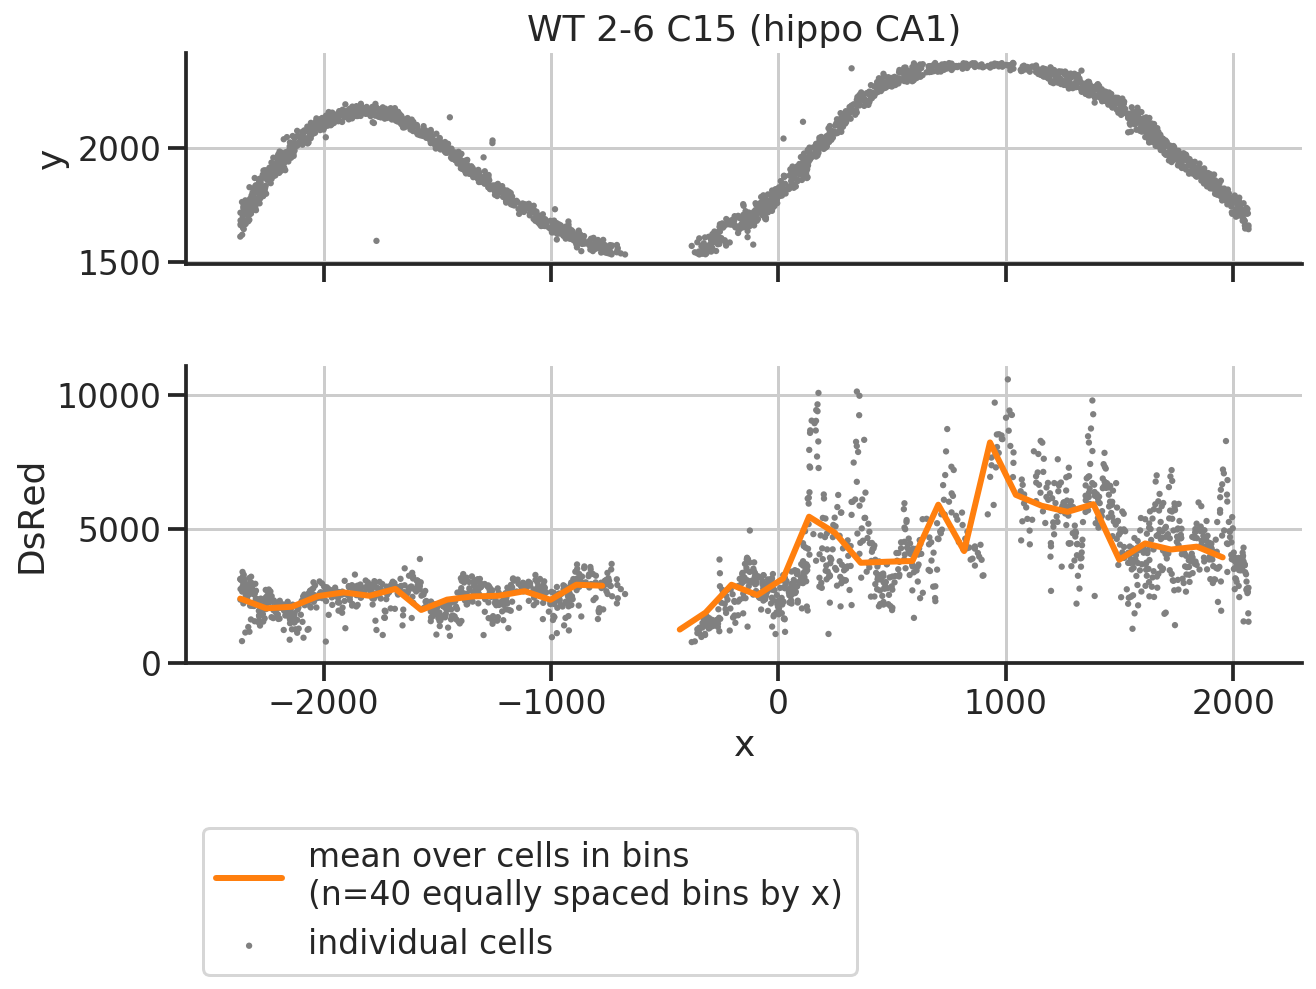

In [158]:
output = figures.format("hippo_CA1_DsRed_level.pdf")
ys = ['y', 'DsRed',]

fig, axs = plt.subplots(len(ys), 1, figsize=(10,3*len(ys)), sharex=True)
for i, y in enumerate(ys):
    ax = axs[i]
    x, y = 'x', y
    sns.scatterplot(ax=ax, data=data, x=x, y=y, s=10, 
                    color='gray',
                    alpha=1,
                    legend=False,
                    edgecolor='none', label='individual cells')
    sns.despine(ax=ax)
    if y == 'y':
        ax.set_aspect('equal')
    if y != 'y': 
        ax.set_ylim(ymin=0)
        ax.plot(xbins[:-1], data_mean[y].values, 
                linewidth=3,
                color='C1', 
                label='mean over cells in bins\n(n={} equally spaced bins by x)'.format(nbins))
        
axs[0].set_title(samples_annot[thesample] + ' C15 (hippo CA1)')
axs[1].legend(bbox_to_anchor=(0,-0.5), loc='upper left')

print(output)
utils.savefig(fig, output)
plt.show()


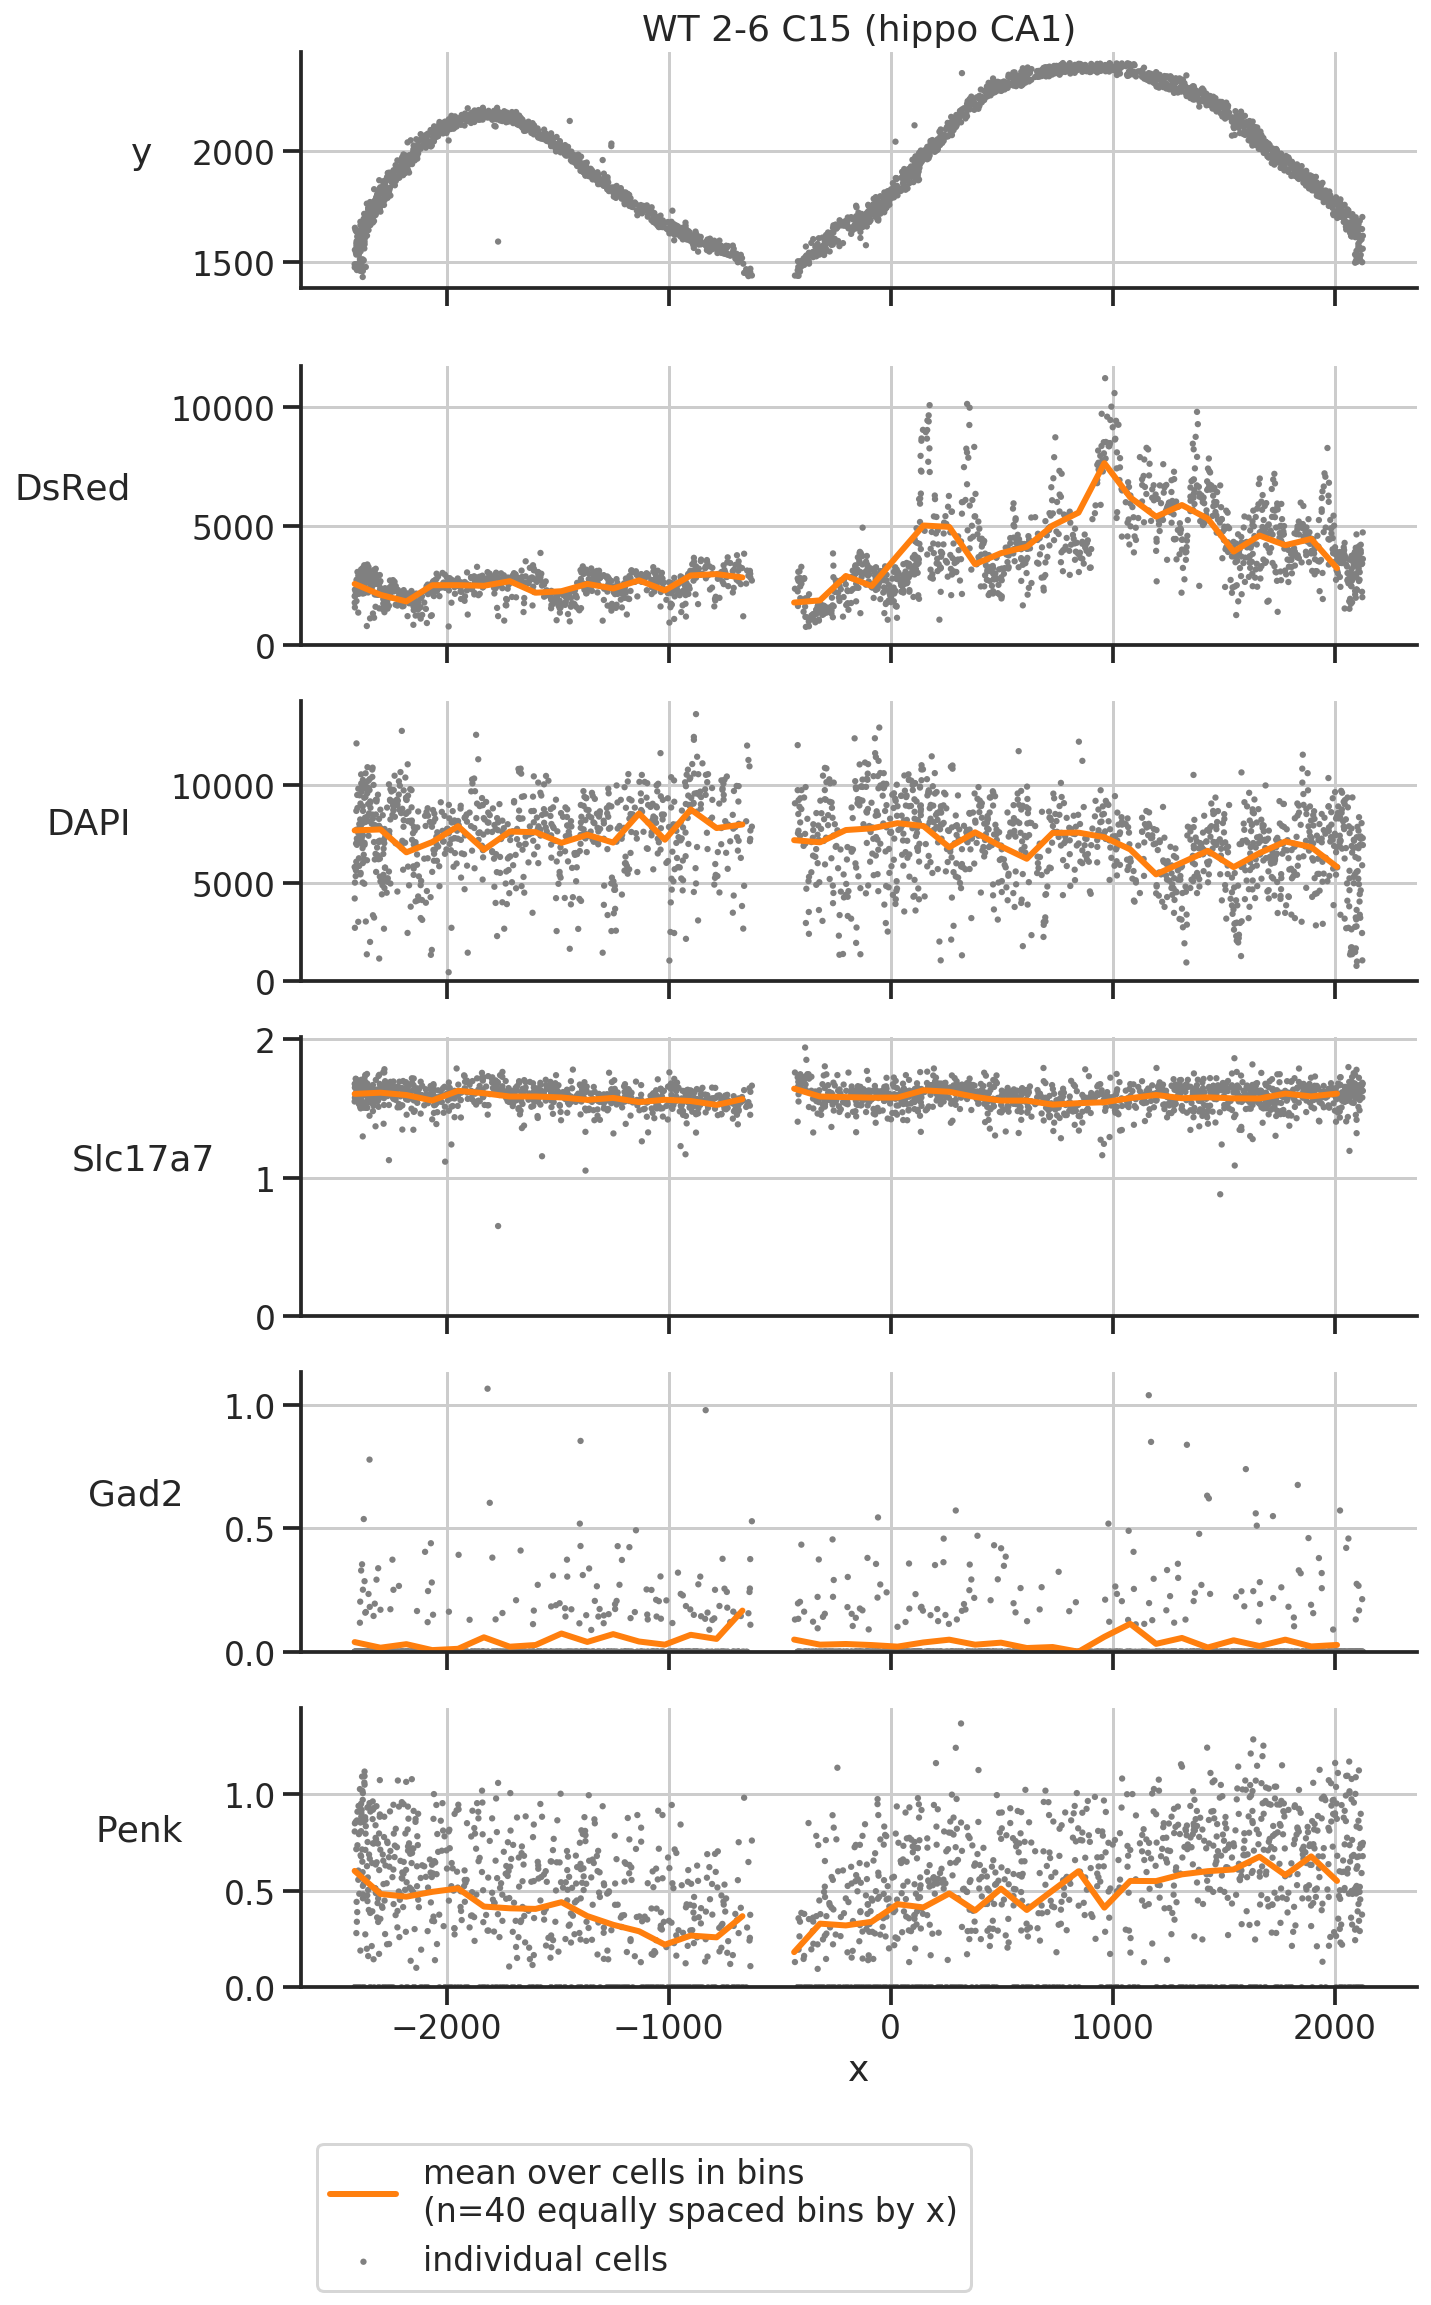

In [178]:
output = figures.format("hippo_CA1_DsRed_level_v2.pdf")
ys = ['y', 'DsRed', 'DAPI', 'Slc17a7', 'Gad2', 'Penk'] #+ genes[gene_prior_idx][:10].tolist()

fig, axs = plt.subplots(len(ys), 1, figsize=(10,3*len(ys)), sharex=True)
for i, y in enumerate(ys):
    ax = axs[i]
    x, y = 'x', y
    sns.scatterplot(ax=ax, data=data, x=x, y=y, s=10, 
                    color='gray',
                    alpha=1,
                    legend=False,
                    edgecolor='none', label='individual cells')
    sns.despine(ax=ax)
    ax.set_ylabel(y, rotation=0, labelpad=20, ha='right')
    if y == 'y':
        ax.set_aspect('equal')
    if y != 'y': 
        ax.set_ylim(ymin=0)
        ax.plot(xbins[:-1], data_mean[y].values, 
                linewidth=3,
                color='C1', 
                label='mean over cells in bins\n(n={} equally spaced bins by x)'.format(nbins))
        
axs[0].set_title(samples_annot[thesample] + ' C15 (hippo CA1)')
axs[-1].legend(bbox_to_anchor=(0,-0.5), loc='upper left')

# print(output)
utils.savefig(fig, output)
plt.show()

In [160]:
tmp = data_mean[genes] #/data_mean[genes].max()

In [164]:
gene_prior_idx = np.nansum(np.abs(tmp.iloc[1:].values-tmp.iloc[:-1].values), axis=0).argsort()[::-1]
genes[gene_prior_idx]

Index(['Slc30a3', 'Penk', 'Nptx1', 'Gfap', 'Fos', 'Ptpru', 'Zbtb20', 'Cck',
       'Chrna7', 'Pkp2',
       ...
       'Bgn', 'Prox1', 'Pdgfra', 'Pitx3', 'Ntf3', 'Kctd4', 'Cux2', 'Nts',
       'Ndnf', 'Igf1'],
      dtype='object', length=150)

In [177]:
data['Penk']
tmp = data[data['x'] > -500]
stats.pearsonr(tmp['x'], tmp['Penk'])

(0.3234002460887584, 1.9378139951663122e-28)

In [165]:
# gene_prior_idx = np.nanmedian(np.abs(tmp.iloc[1:].values-tmp.iloc[:-1].values), axis=0).argsort()[::-1]
# genes[gene_prior_idx]

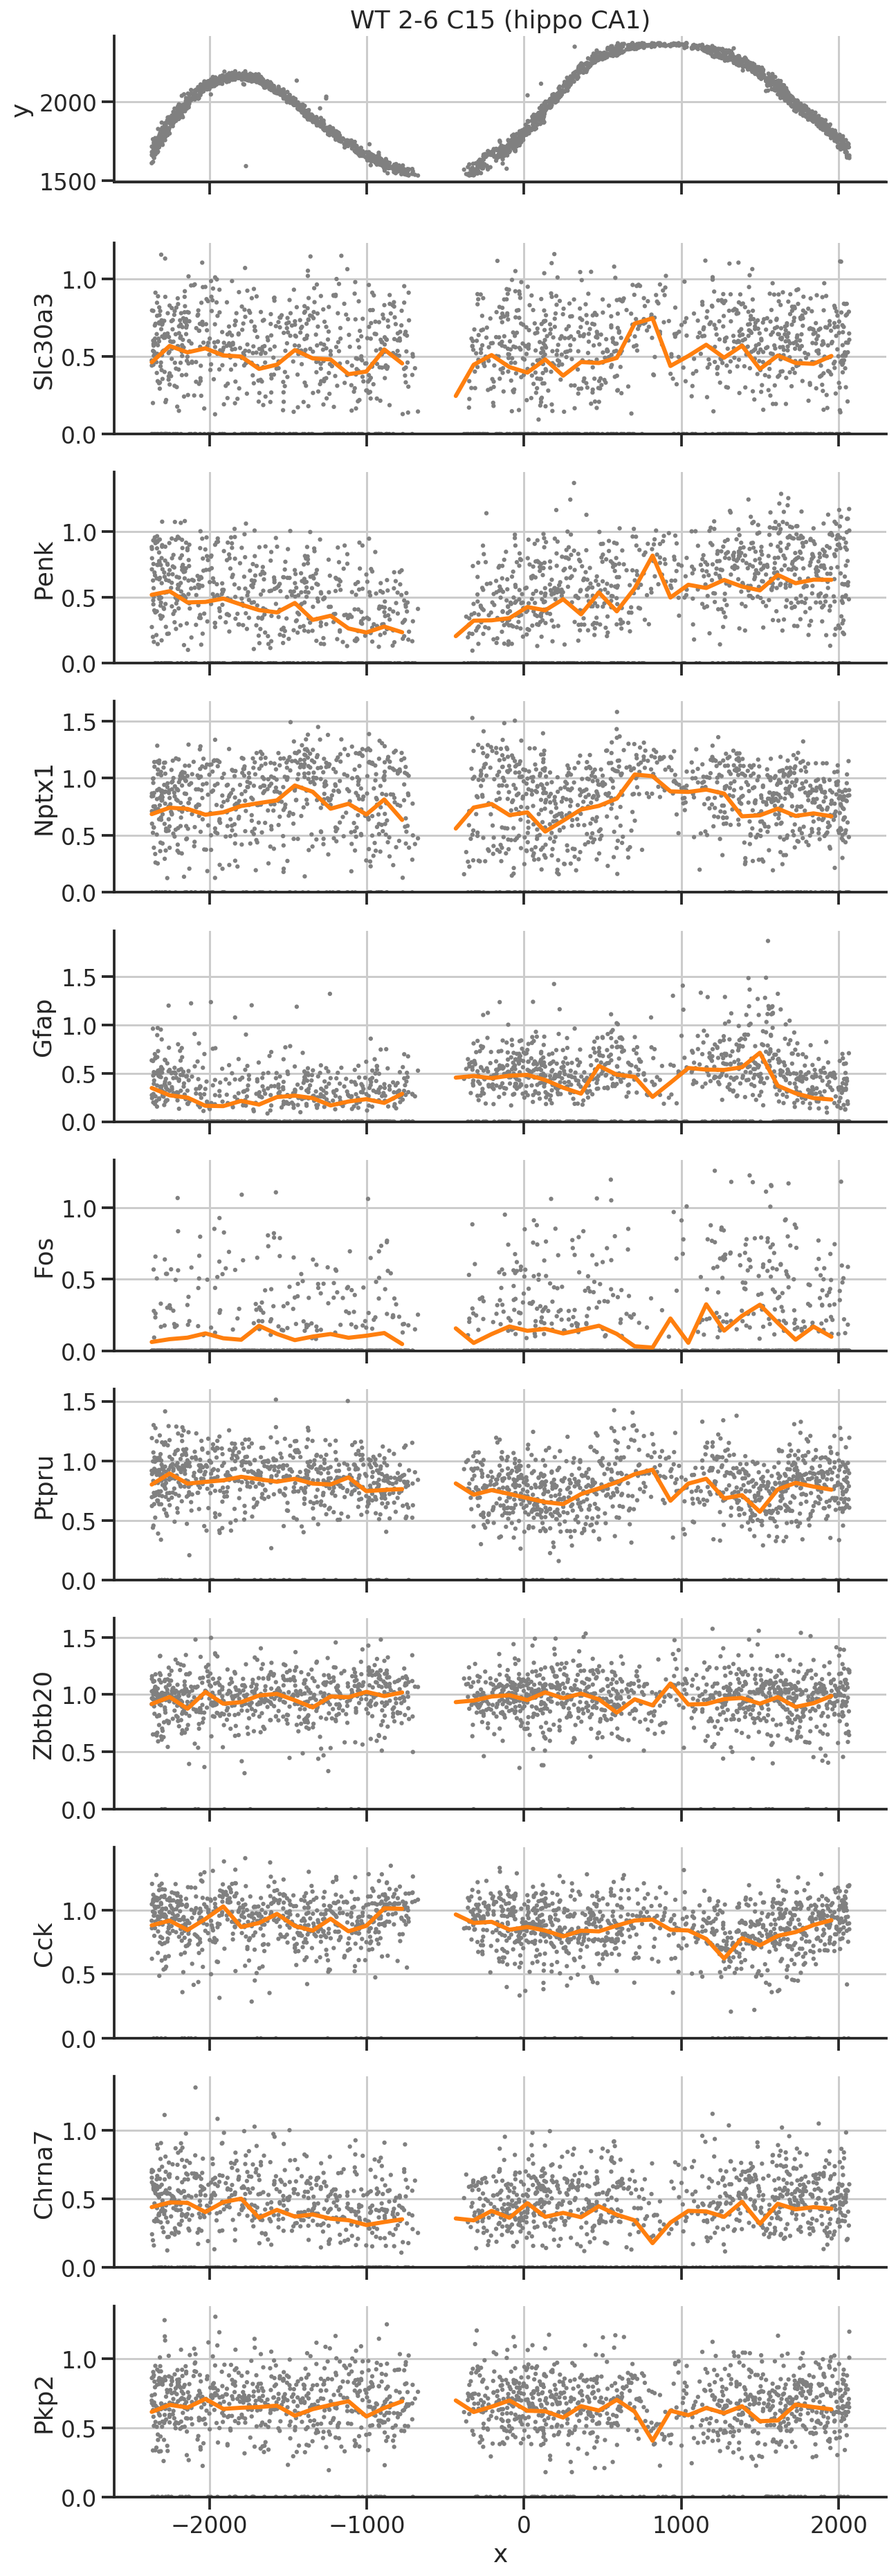

In [166]:
# output = figures.format("hippo_CA1_DsRed_level_v3.pdf")
ys = ['y'] + genes[gene_prior_idx][:10].tolist()

fig, axs = plt.subplots(len(ys), 1, figsize=(10,3*len(ys)), sharex=True)
for i, y in enumerate(ys):
    ax = axs[i]
    x, y = 'x', y
    sns.scatterplot(ax=ax, data=data, x=x, y=y, s=10, 
                    color='gray',
                    alpha=1,
                    legend=False,
                    edgecolor='none', label='individual cells')
    sns.despine(ax=ax)
    if y == 'y':
        ax.set_aspect('equal')
    if y != 'y': 
        ax.set_ylim(ymin=0)
        ax.plot(xbins[:-1], data_mean[y].values, 
                linewidth=3,
                color='C1', 
                label='mean over cells in bins\n(n={} equally spaced bins by x)'.format(nbins))
        
axs[0].set_title(samples_annot[thesample] + ' C15 (hippo CA1)')
axs[1].legend(bbox_to_anchor=(0,-0.5), loc='upper left')

# print(output)
# utils.savefig(fig, output)
plt.show()